<a href="https://colab.research.google.com/github/Sai-Vara-Prasad-Lekkalapudi/major-project/blob/main/Copy_of_Major_project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Major project

##Project Topic:
Financial Feature Optimization for Corporate Bankruptcy Prediction using Gradient Boosting Models.

##Dataset: https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data
##Research question:
Which financial indicators are most influential in predicting corporate bankruptcy, and how does feature selection affect model performance
##Goal:
My aim is to identify the most important financial features influencing bankruptcy prediction and to understand how feature selection and dimensionality reduction affect both accuracy and interpretability of machine learning models.


In [ ]:
# Importing required libraries
import pandas as pd
from scipy.io import arff
import urllib.request

#  List all 5 years ARFF file URLs from github raw data
urls = [
    'https://raw.githubusercontent.com/Sai-Vara-Prasad-Lekkalapudi/major-project/refs/heads/main/1year.arff',
    'https://raw.githubusercontent.com/Sai-Vara-Prasad-Lekkalapudi/major-project/refs/heads/main/2year.arff',
    'https://raw.githubusercontent.com/Sai-Vara-Prasad-Lekkalapudi/major-project/refs/heads/main/3year.arff',
    'https://raw.githubusercontent.com/Sai-Vara-Prasad-Lekkalapudi/major-project/refs/heads/main/4year.arff',
    'https://raw.githubusercontent.com/Sai-Vara-Prasad-Lekkalapudi/major-project/refs/heads/main/5year.arff'
]

# Downloading and loading each file into a dictionary of DataFrames
dfs = {}
for url in urls:
    year = url.split('/')[-1].split('.')[0]
    local_path = f'/content/{year}.arff'
    urllib.request.urlretrieve(url, local_path)
    data, meta = arff.loadarff(local_path)
    dfs[year] = pd.DataFrame(data)
    print(f"\nLoaded {year}: shape = {dfs[year].shape}")
    print(dfs[year].info())




Loaded 1year: shape = (7027, 65)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   7024 non-null   float64
 1   Attr2   7024 non-null   float64
 2   Attr3   7024 non-null   float64
 3   Attr4   6997 non-null   float64
 4   Attr5   7019 non-null   float64
 5   Attr6   7024 non-null   float64
 6   Attr7   7024 non-null   float64
 7   Attr8   7002 non-null   float64
 8   Attr9   7026 non-null   float64
 9   Attr10  7024 non-null   float64
 10  Attr11  6988 non-null   float64
 11  Attr12  6997 non-null   float64
 12  Attr13  7027 non-null   float64
 13  Attr14  7024 non-null   float64
 14  Attr15  7025 non-null   float64
 15  Attr16  7002 non-null   float64
 16  Attr17  7002 non-null   float64
 17  Attr18  7024 non-null   float64
 18  Attr19  7027 non-null   float64
 19  Attr20  7027 non-null   float64
 20  Attr21  5405 non-null   float64
 21  Att

I have successfully loaded all five datasets (1-year to 5-year) from the Polish Companies Bankruptcy dataset. Each file represents a different forecasting horizon - predicting whether a company will go bankrupt within 1 to 5 years.

Each dataset contains 64 financial indicators and 1 target variable (class), showing if a firm is bankrupt (b) or non-bankrupt (n). The number of records varies slightly across years, but all share the same structure and features.

From my observation:

The schema of all files is consistent (Attr1 - Attr64 + class).

Some attributes have missing values (especially in Attr21, Attr37, Attr45, and Attr60).

There is a high class imbalance — only a small portion of companies are bankrupt.

This gives me a clear base to proceed with data preprocessing, feature selection, and model training for bankruptcy prediction.

# Data Understanding (Exploration) EDA

Dataset Shape: (7027, 65)
Number of Missing Values:
 5835


/tmp/ipython-input-4278658148.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='coolwarm')


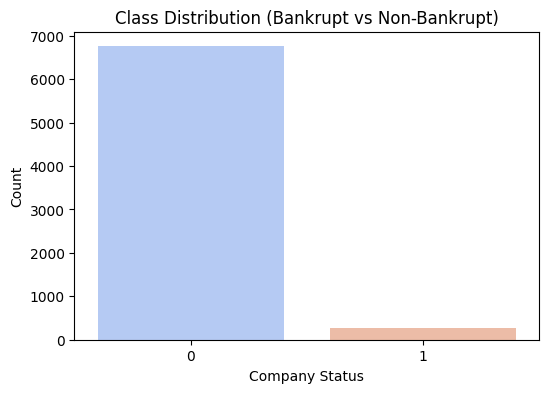

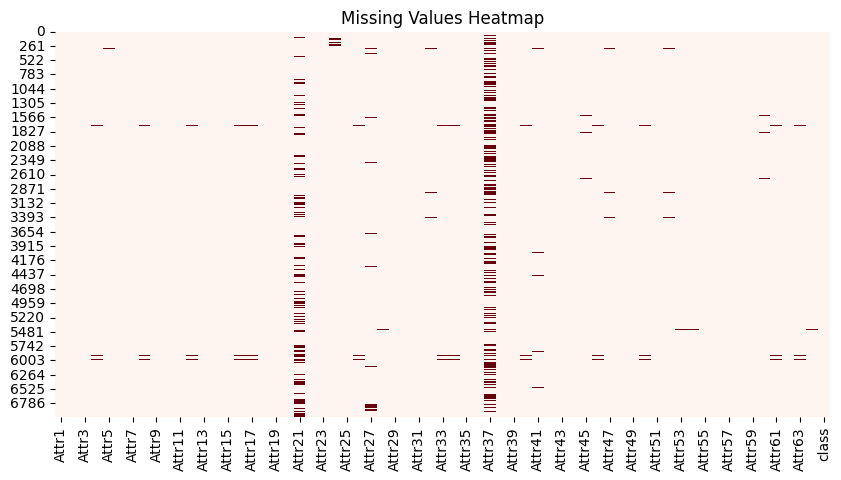

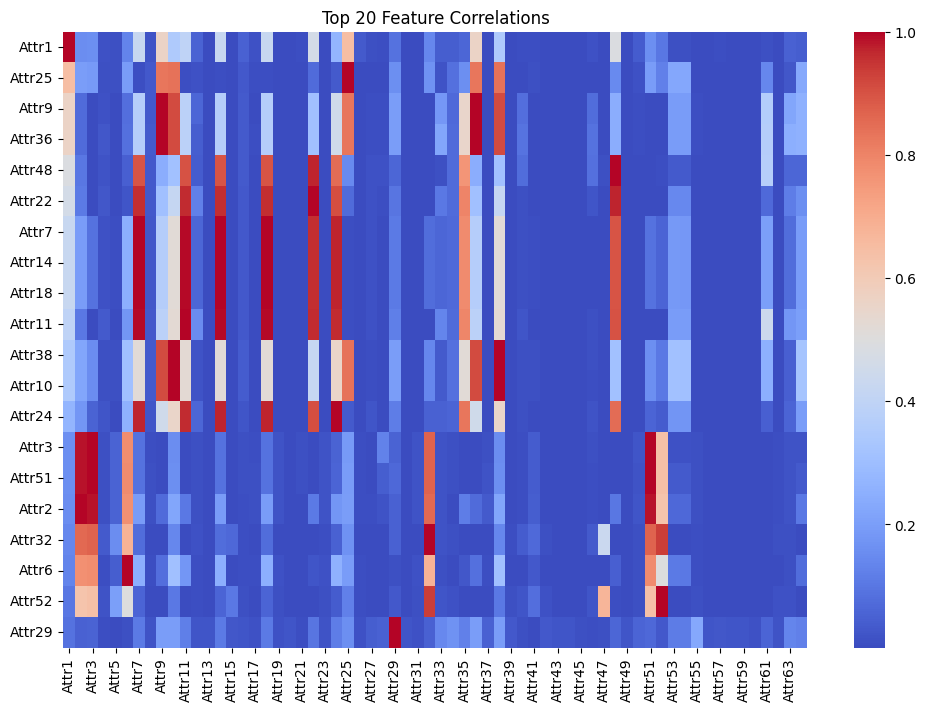

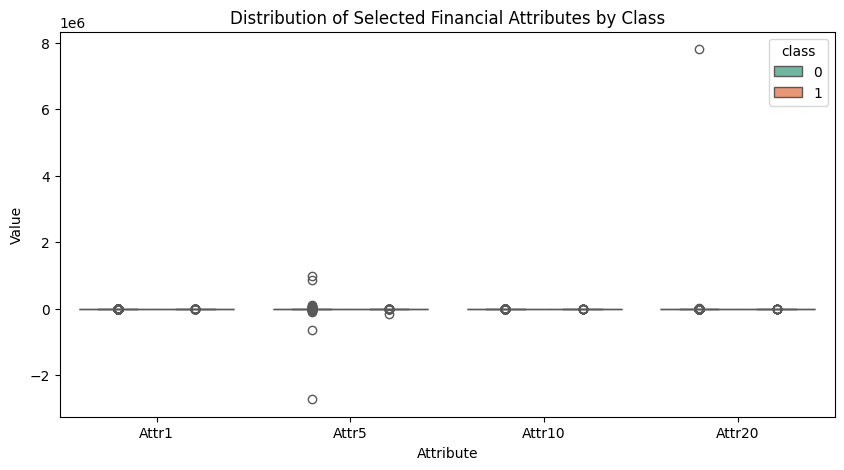

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year data to visualize
df = dfs['1year'].copy()

# Decode the 'class' column if needed
if isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].str.decode('utf-8')

# Basic Info
print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isnull().sum().sum())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='coolwarm')
plt.title('Class Distribution (Bankrupt vs Non-Bankrupt)')
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

# Missing Values Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Heatmap (Top 20 features)
plt.figure(figsize=(12,8))
corr = df.drop('class', axis=1).corr()
sns.heatmap(corr.abs().nlargest(20, 'Attr1'), cmap='coolwarm', annot=False)
plt.title('Top 20 Feature Correlations')
plt.show()

# Boxplot Example: Distribution of a few financial ratios
plt.figure(figsize=(10,5))
sample_features = ['Attr1','Attr5','Attr10','Attr20']
df_melt = df.melt(id_vars='class', value_vars=sample_features, var_name='Attribute', value_name='Value')
sns.boxplot(x='Attribute', y='Value', hue='class', data=df_melt, palette='Set2')
plt.title('Distribution of Selected Financial Attributes by Class')
plt.show()


Dataset Shape: (10173, 65)
Number of Missing Values:
 12157


/tmp/ipython-input-3426513962.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='coolwarm')


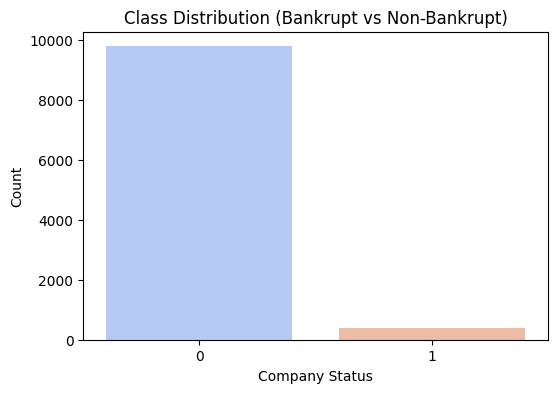

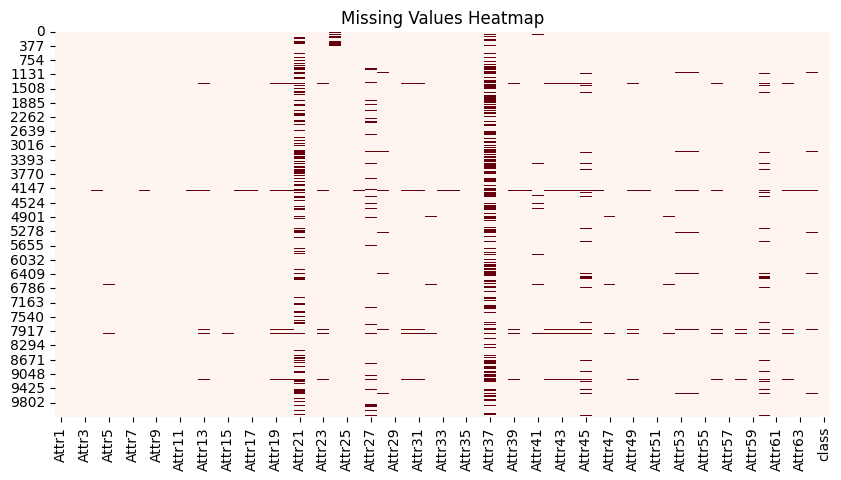

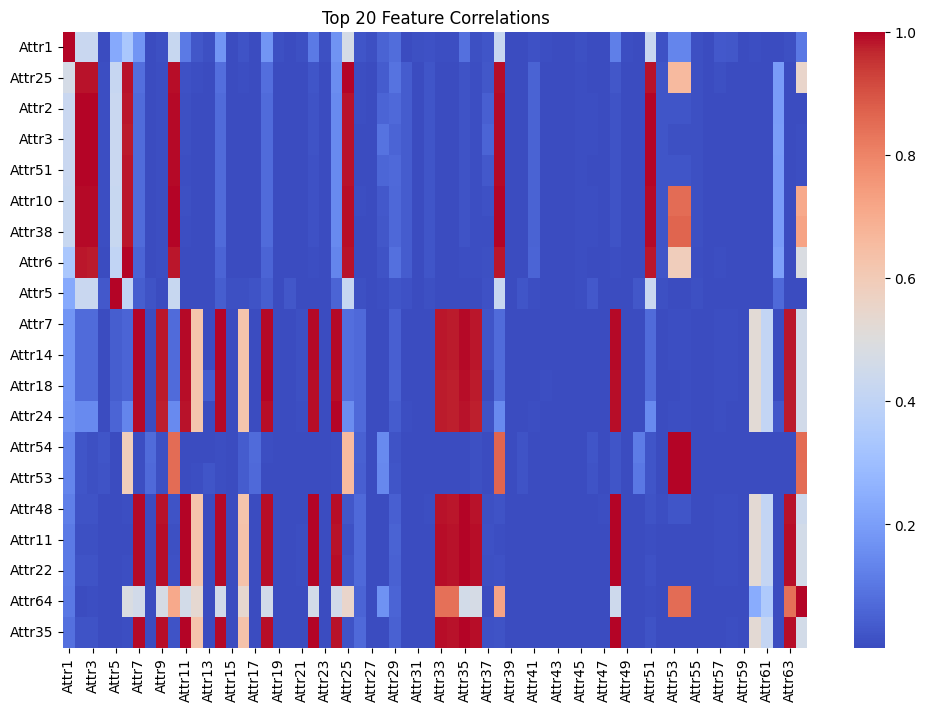

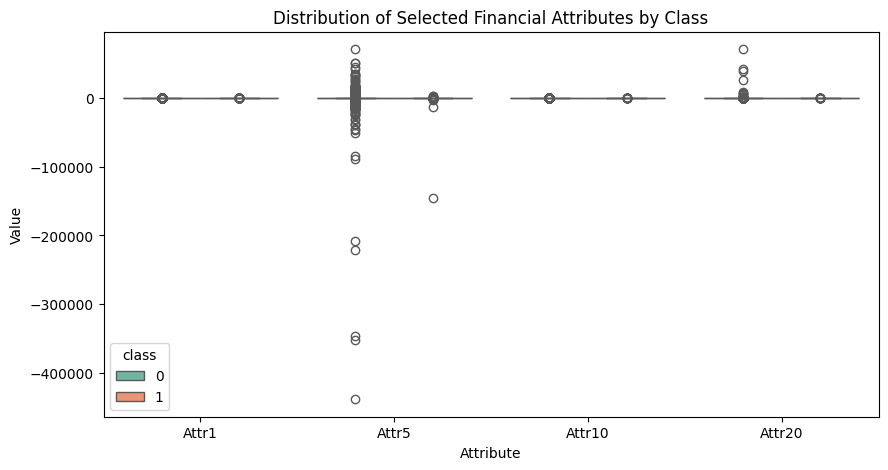

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year data to visualize
df = dfs['2year'].copy()

# Decode the 'class' column if needed
if isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].str.decode('utf-8')

# Basic Info
print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isnull().sum().sum())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='coolwarm')
plt.title('Class Distribution (Bankrupt vs Non-Bankrupt)')
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

# Missing Values Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Heatmap (Top 20 features)
plt.figure(figsize=(12,8))
corr = df.drop('class', axis=1).corr()
sns.heatmap(corr.abs().nlargest(20, 'Attr1'), cmap='coolwarm', annot=False)
plt.title('Top 20 Feature Correlations')
plt.show()

# Boxplot Example: Distribution of a few financial ratios
plt.figure(figsize=(10,5))
sample_features = ['Attr1','Attr5','Attr10','Attr20']
df_melt = df.melt(id_vars='class', value_vars=sample_features, var_name='Attribute', value_name='Value')
sns.boxplot(x='Attribute', y='Value', hue='class', data=df_melt, palette='Set2')
plt.title('Distribution of Selected Financial Attributes by Class')
plt.show()


Dataset Shape: (10503, 65)
Number of Missing Values:
 9888


/tmp/ipython-input-1660120595.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='coolwarm')


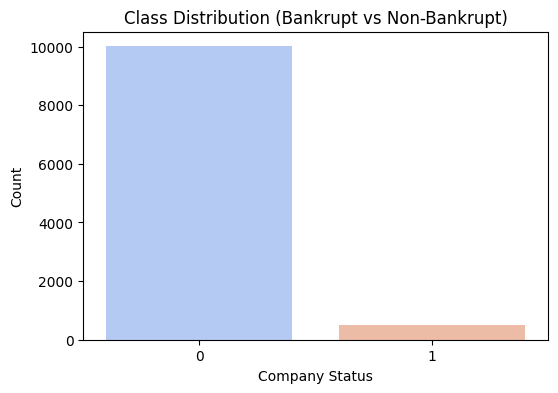

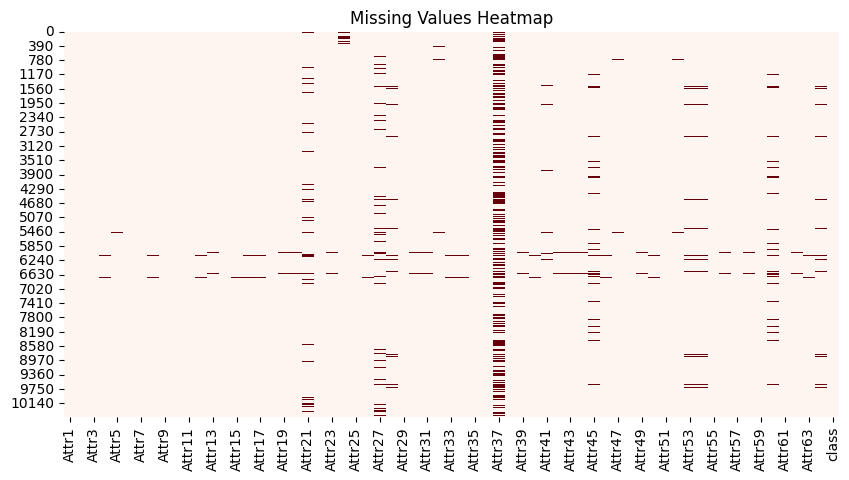

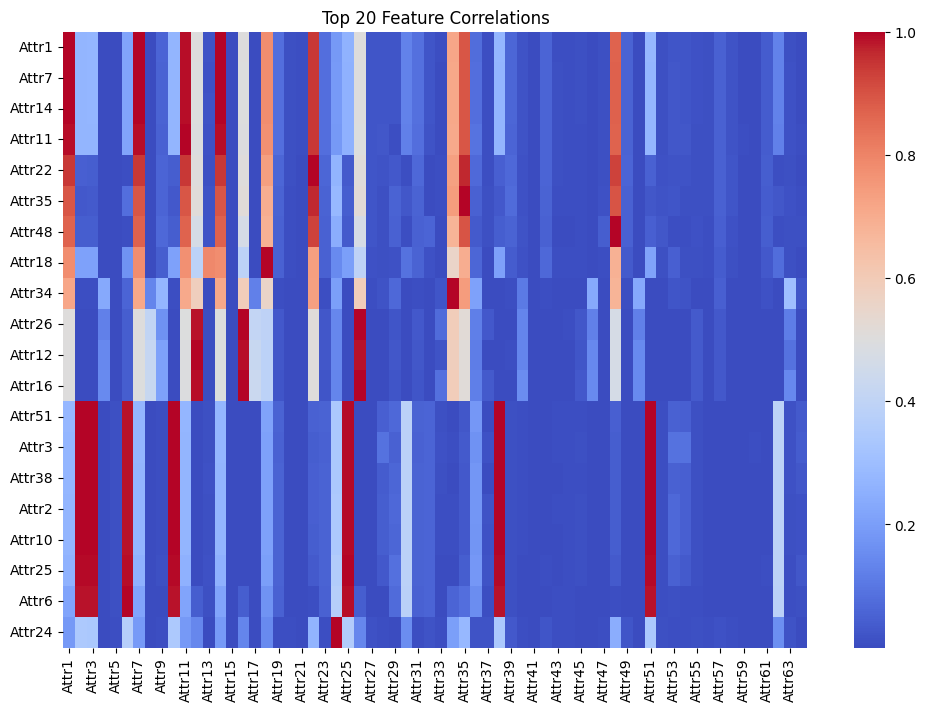

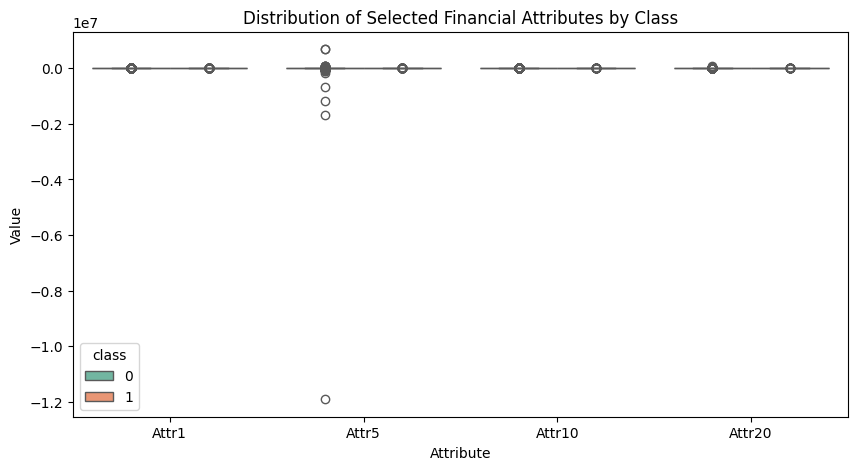

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year data to visualize
df = dfs['3year'].copy()

# Decode the 'class' column if needed
if isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].str.decode('utf-8')

# Basic Info
print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isnull().sum().sum())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='coolwarm')
plt.title('Class Distribution (Bankrupt vs Non-Bankrupt)')
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

# Missing Values Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Heatmap (Top 20 features)
plt.figure(figsize=(12,8))
corr = df.drop('class', axis=1).corr()
sns.heatmap(corr.abs().nlargest(20, 'Attr1'), cmap='coolwarm', annot=False)
plt.title('Top 20 Feature Correlations')
plt.show()

# Boxplot Example: Distribution of a few financial ratios
plt.figure(figsize=(10,5))
sample_features = ['Attr1','Attr5','Attr10','Attr20']
df_melt = df.melt(id_vars='class', value_vars=sample_features, var_name='Attribute', value_name='Value')
sns.boxplot(x='Attribute', y='Value', hue='class', data=df_melt, palette='Set2')
plt.title('Distribution of Selected Financial Attributes by Class')
plt.show()


Dataset Shape: (9792, 65)
Number of Missing Values:
 8776


/tmp/ipython-input-4050274266.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='coolwarm')


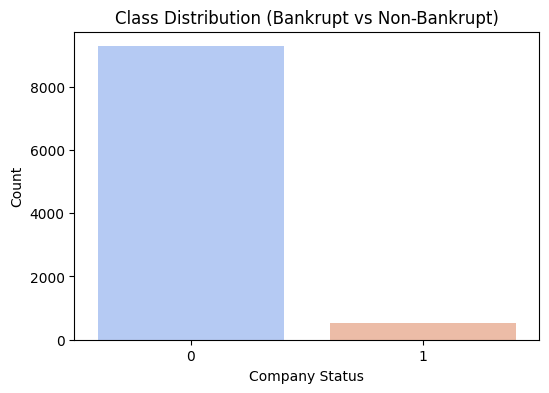

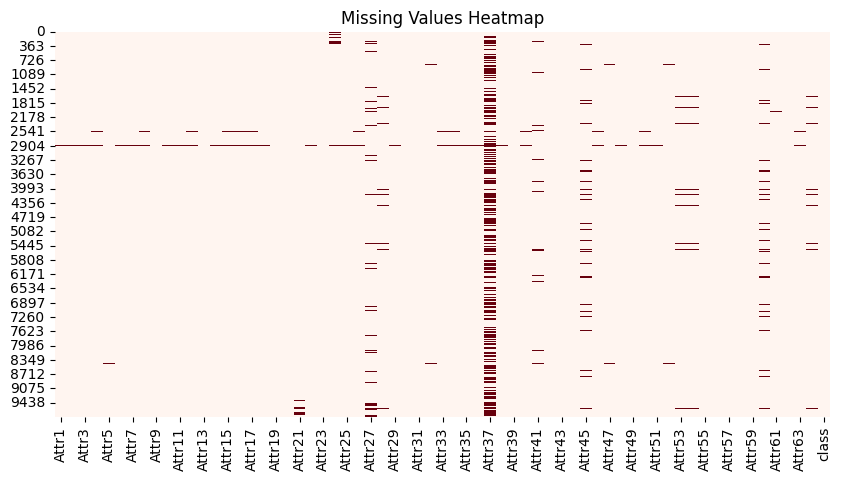

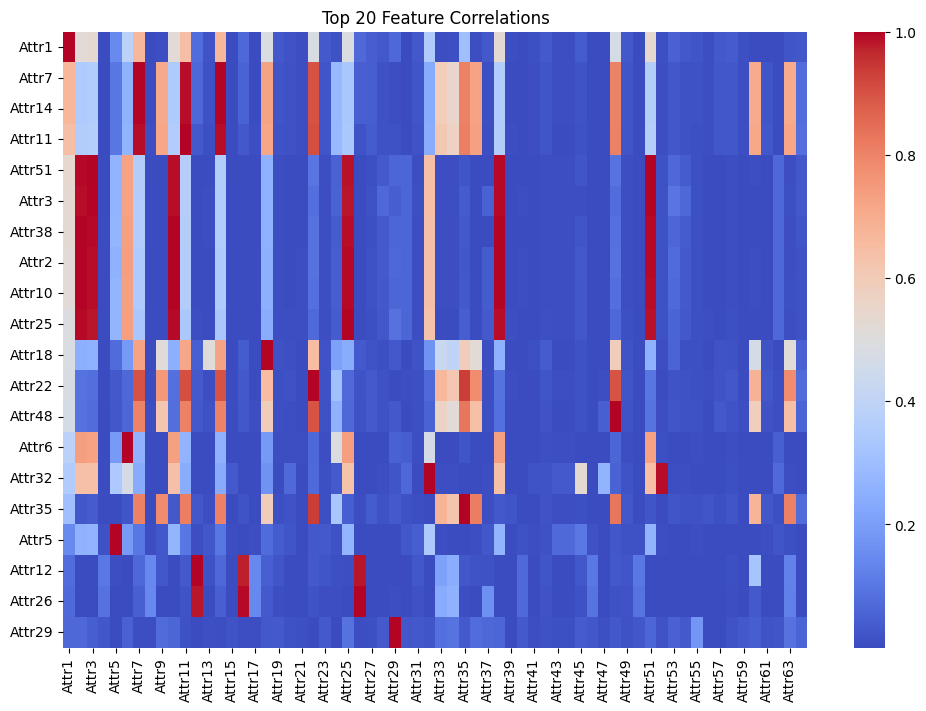

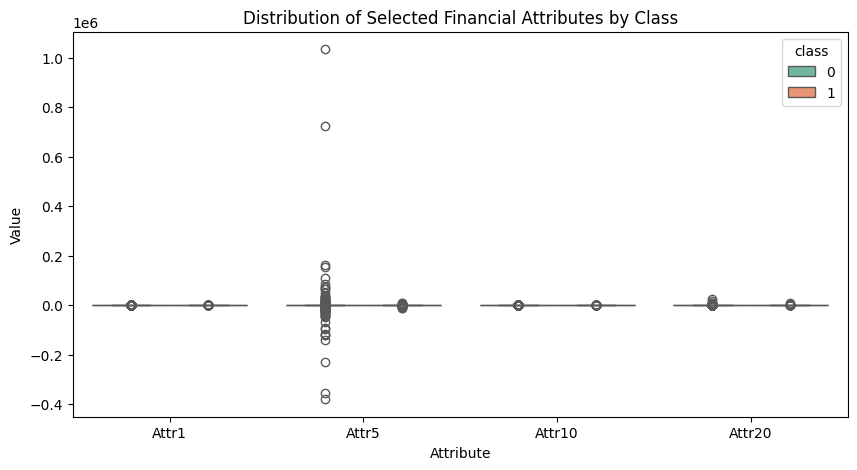

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year data to visualize
df = dfs['4year'].copy()

# Decode the 'class' column if needed
if isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].str.decode('utf-8')

# Basic Info
print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isnull().sum().sum())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='coolwarm')
plt.title('Class Distribution (Bankrupt vs Non-Bankrupt)')
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

# Missing Values Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Heatmap (Top 20 features)
plt.figure(figsize=(12,8))
corr = df.drop('class', axis=1).corr()
sns.heatmap(corr.abs().nlargest(20, 'Attr1'), cmap='coolwarm', annot=False)
plt.title('Top 20 Feature Correlations')
plt.show()

# Boxplot Example: Distribution of a few financial ratios
plt.figure(figsize=(10,5))
sample_features = ['Attr1','Attr5','Attr10','Attr20']
df_melt = df.melt(id_vars='class', value_vars=sample_features, var_name='Attribute', value_name='Value')
sns.boxplot(x='Attribute', y='Value', hue='class', data=df_melt, palette='Set2')
plt.title('Distribution of Selected Financial Attributes by Class')
plt.show()


Dataset Shape: (5910, 65)
Number of Missing Values:
 4666


/tmp/ipython-input-2434403198.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='coolwarm')


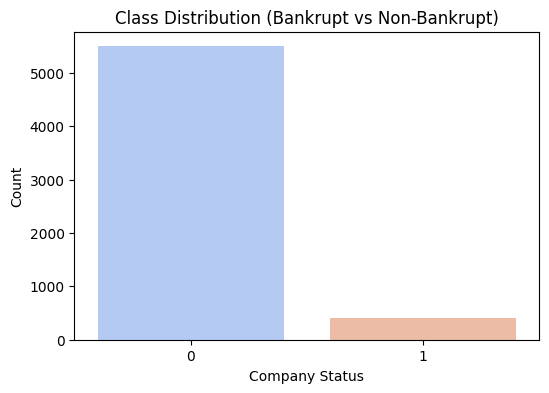

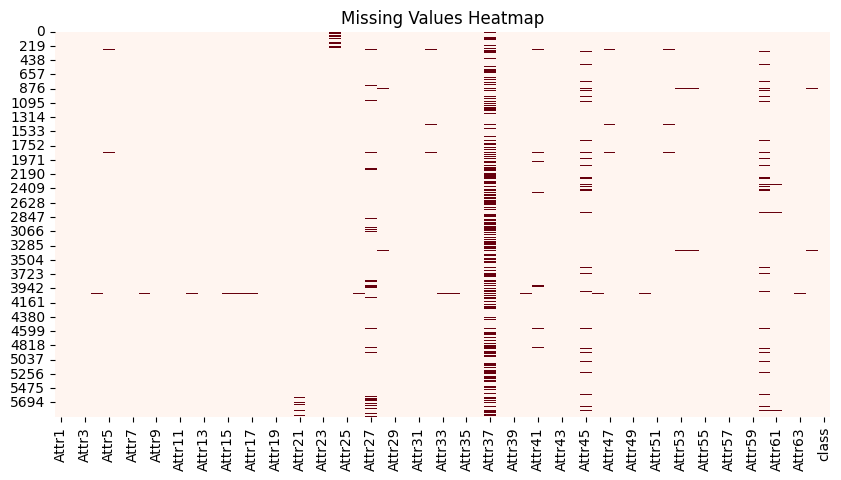

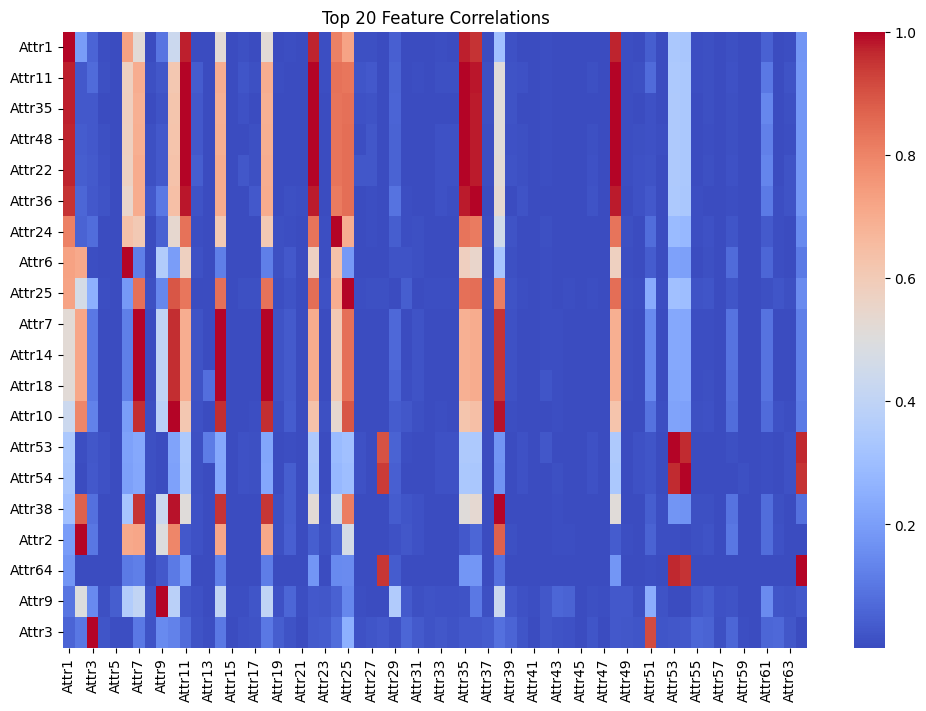

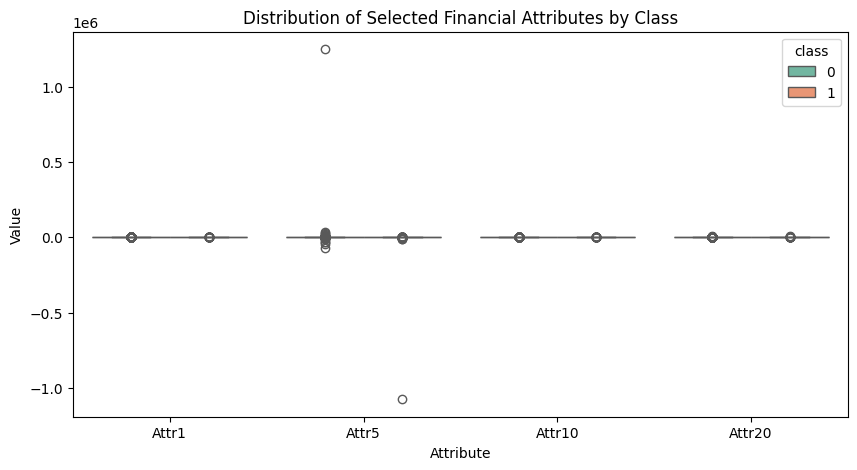

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year data to visualize
df = dfs['5year'].copy()

# Decode the 'class' column if needed
if isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].str.decode('utf-8')

# Basic Info
print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isnull().sum().sum())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='coolwarm')
plt.title('Class Distribution (Bankrupt vs Non-Bankrupt)')
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

# Missing Values Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Heatmap (Top 20 features)
plt.figure(figsize=(12,8))
corr = df.drop('class', axis=1).corr()
sns.heatmap(corr.abs().nlargest(20, 'Attr1'), cmap='coolwarm', annot=False)
plt.title('Top 20 Feature Correlations')
plt.show()

# Boxplot Example: Distribution of a few financial ratios
plt.figure(figsize=(10,5))
sample_features = ['Attr1','Attr5','Attr10','Attr20']
df_melt = df.melt(id_vars='class', value_vars=sample_features, var_name='Attribute', value_name='Value')
sns.boxplot(x='Attribute', y='Value', hue='class', data=df_melt, palette='Set2')
plt.title('Distribution of Selected Financial Attributes by Class')
plt.show()


# Data Preparation (Preprocessing & Feature Engineering)

I observed that each feature in the Polish Bankruptcy dataset represents an important financial ratio (like debt ratio, liquidity, and profitability). Even if some values are missing, they still carry meaningful information about a company's financial condition.
So instead of dropping columns with missing data, I decided to impute the missing values using the median.
This helps me keep all 64 financial features for analysis and ensures that no important financial indicator is lost, which is important for understanding feature importance and model interpretability later

In [ ]:
# Missing Value Analysis & Imputation

import pandas as pd
from sklearn.impute import SimpleImputer

datasets = {
    "1-Year": dfs["1year"].copy(),
    "2-Year": dfs["2year"].copy(),
    "3-Year": dfs["3year"].copy(),
    "4-Year": dfs["4year"].copy(),
    "5-Year": dfs["5year"].copy()
}

#  Check missing values before imputation
print(" Missing Values Before Imputation:\n")
before_counts = {}
for name, df in datasets.items():
    missing_count = df.isnull().sum().sum()
    before_counts[name] = missing_count
    print(f"{name} dataset → {missing_count} missing values")

#  Apply median imputation for numeric columns
imputer = SimpleImputer(strategy="median")

for name, df in datasets.items():
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    datasets[name] = df

#  Verify missing values after imputation
print("\n Missing Values After Imputation:\n")
after_counts = {}
for name, df in datasets.items():
    missing_count = df.isnull().sum().sum()
    after_counts[name] = missing_count
    print(f"{name} dataset → {missing_count} missing values")

#  Displaying before-after summary table
before_after = pd.DataFrame({
    "Dataset": list(datasets.keys()),
    "Before Imputation": list(before_counts.values()),
    "After Imputation": list(after_counts.values())
})

print("\n Before vs After Imputation Summary:\n")
display(before_after)


 Missing Values Before Imputation:

1-Year dataset → 5835 missing values
2-Year dataset → 12157 missing values
3-Year dataset → 9888 missing values
4-Year dataset → 8776 missing values
5-Year dataset → 4666 missing values

 Missing Values After Imputation:

1-Year dataset → 0 missing values
2-Year dataset → 0 missing values
3-Year dataset → 0 missing values
4-Year dataset → 0 missing values
5-Year dataset → 0 missing values

 Before vs After Imputation Summary:



Dataset  Before Imputation  After Imputation
0  1-Year               5835                 0
1  2-Year              12157                 0
2  3-Year               9888                 0
3  4-Year               8776                 0
4  5-Year               4666                 0

I observed that each year's dataset contained a different number of missing values across the financial attributes.
To preserve all important financial indicators, I decided not to drop any columns but instead applied median imputation.
After imputation, all missing values were successfully filled, resulting in complete datasets for all 1 - 5 year files.
This ensures consistent input quality for model training and fair comparison across forecasting horizons.

# Class Imbalance Handling

I observed that the bankruptcy datasets are highly imbalanced, with far fewer bankrupt companies compared to non-bankrupt ones.
To prevent bias in the machine learning models and ensure fair learning, I applied SMOTE to oversample the minority (bankrupt) class.
After balancing, both classes have approximately equal representation in the training data, improving model generalization.

Handle Class Imbalance -SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset.

Feature Scaling (StandardScaler or MinMaxScaler)

Optional Outlier Removal

Feature Engineering (Ratios, Log Transform, etc.)

Feature Selection (RFE, PCA, SHAP)


I observed that a few rows had missing target (class) values. Since these samples do not provide any bankruptcy status label, I dropped them to ensure the model trains only on valid labeled data. This step does not affect feature information, as all financial attributes were previously imputed using the median strategy.

In [ ]:
# checking 1 year missing data

df = dfs['1year'].copy()

# Decode bytes
if df['class'].dtype == 'object' or isinstance(df['class'].iloc[0], bytes):
    df['class'] = df['class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Converting class to numeric (0 or 1)
df['class'] = df['class'].astype(float)

# Checking unique values
print("Unique target values:", df['class'].unique())
print("Number of NaNs in target:", df['class'].isna().sum())


Unique target values: [0. 1.]
Number of NaNs in target: 0


Class distribution before SMOTE: Counter({0: 6756, 1: 271})
Class distribution after SMOTE: Counter({0: 5404, 1: 5404})


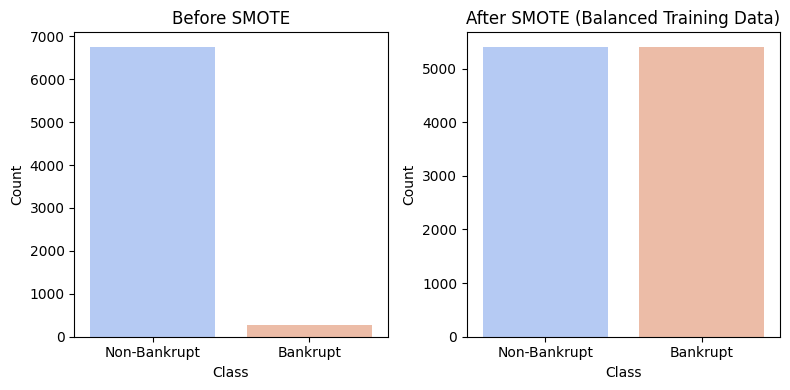

In [ ]:
# Handling Class Imbalance (SMOTE)

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Select the cleaned dataset
df_bal = datasets['1-Year'].copy()

# Decode bytes if necessary
if isinstance(df_bal['class'].iloc[0], bytes):
    df_bal['class'] = df_bal['class'].str.decode('utf-8')

# Convert target column to integer (0 or 1)
df_bal['class'] = df_bal['class'].astype(float).astype(int)

# Separate features and target
X = df_bal.drop('class', axis=1)
y = df_bal['class']

# Check initial class balance
print("Class distribution before SMOTE:", Counter(y))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check class balance after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_res))

#  Visualization
plt.figure(figsize=(8,4))

# Before SMOTE
plt.subplot(1,2,1)
sns.barplot(x=['Non-Bankrupt', 'Bankrupt'],
            y=list(Counter(y).values()),
            hue=['Non-Bankrupt', 'Bankrupt'],
            palette="coolwarm", legend=False)
plt.title("Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1,2,2)
sns.barplot(x=['Non-Bankrupt', 'Bankrupt'],
            y=list(Counter(y_train_res).values()),
            hue=['Non-Bankrupt', 'Bankrupt'],
            palette="coolwarm", legend=False)
plt.title("After SMOTE (Balanced Training Data)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# Outlier Detection & Treatment

Summary BEFORE outlier treatment:
            mean           std         min         max
Attr1   0.029029      3.633901    -256.890      94.280
Attr2   0.574511      0.813860     -72.162      21.261
Attr3   0.116860      0.412586     -21.234       1.000
Attr4   2.554616     12.887875       0.000    1017.800
Attr5  83.564696  14298.873955 -634140.000  990900.000

Summary AFTER outlier treatment:
            mean        std         min         max
Attr1   0.067263   0.114040   -0.176375    0.310416
Attr2   0.565997   0.280694   -0.231814    1.335622
Attr3   0.131767   0.278024   -0.568255    0.855389
Attr4   1.695390   1.077739    0.000000    4.059161
Attr5 -17.101225  77.987969 -179.071048  148.182229


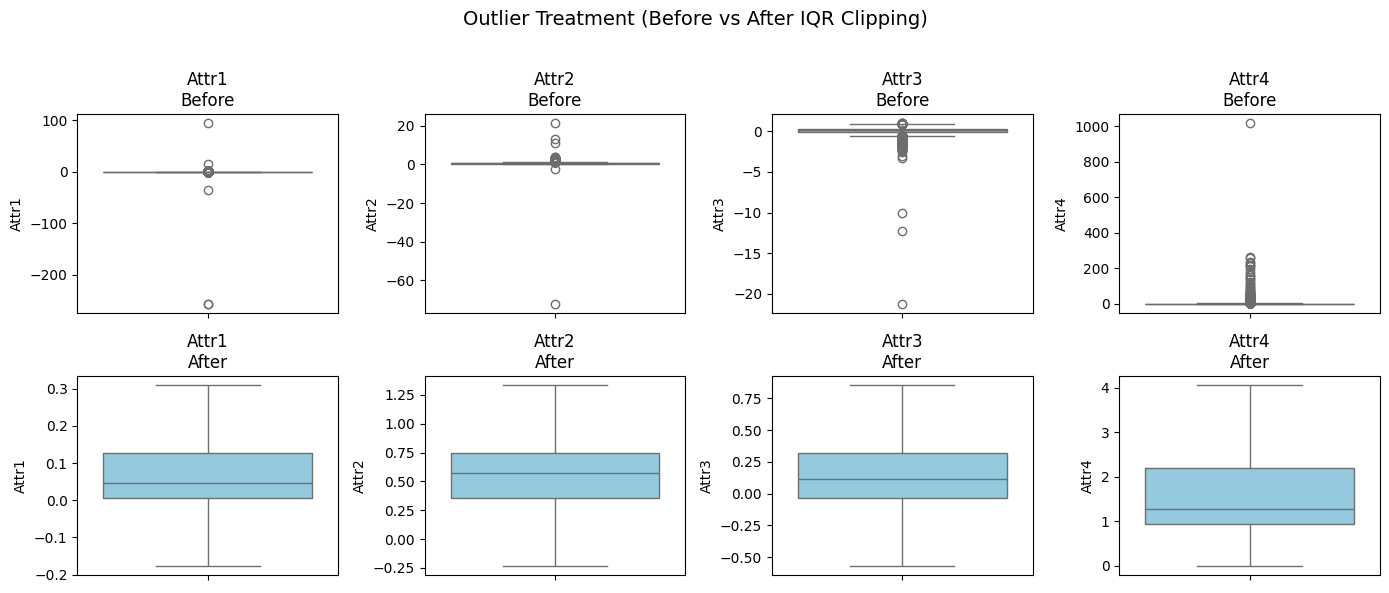

In [ ]:
#  Outlier Detection & Treatment (IQR Method + Visualization)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Working on SMOTE-balanced training data
X_train_out = X_train_res.copy()

#  Summary before clipping
print("Summary BEFORE outlier treatment:")
print(X_train_out.describe().T[['mean', 'std', 'min', 'max']].head(5))

#  IQR-based clipping
for col in X_train_out.columns:
    Q1 = X_train_out[col].quantile(0.25)
    Q3 = X_train_out[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X_train_out[col] = np.clip(X_train_out[col], lower_bound, upper_bound)

# Summary after clipping
print("\nSummary AFTER outlier treatment:")
print(X_train_out.describe().T[['mean', 'std', 'min', 'max']].head(5))

#  Quick visualization for a few numerical columns
numeric_cols = X_train_out.select_dtypes(include=[np.number]).columns[:4]

plt.figure(figsize=(14, 6))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=X_train_res[col], color='salmon')
    plt.title(f"{col}\nBefore")

    plt.subplot(2, 4, i+4)
    sns.boxplot(y=X_train_out[col], color='skyblue')
    plt.title(f"{col}\nAfter")

plt.suptitle("Outlier Treatment (Before vs After IQR Clipping)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



I observed that several financial attributes (like Attr1, Attr4, and Attr5) had extreme outlier values before treatment for example, Attr5 ranged from 634,140 to 990,900, indicating possible data entry or scale distortions.

To make the dataset more stable and suitable for modeling, I applied IQR-based clipping, which limits values outside 1.5x the interquartile range.

After clipping:

The standard deviation of most attributes decreased sharply (e.g, Attr5 from 14,298 → 78),

The range of values became more realistic and consistent,

The overall data distribution became tighter and less skewed, improving model robustness.

This ensures that extreme values don't dominate the learning process and helps models like Logistic Regression, SVM, or KNN perform better.

# Feature Scaling


Summary BEFORE Scaling (Training Data):
      Attr1  Attr2  Attr3  Attr4    Attr5  Attr6  Attr7  Attr8  Attr9  Attr10  \
mean  0.067  0.566  0.132  1.695  -17.101  0.020  0.083  1.297  1.717   0.409   
std   0.114  0.281  0.278  1.078   77.988  0.075  0.133  1.360  0.930   0.283   
min  -0.176 -0.232 -0.568  0.000 -179.071 -0.097 -0.208 -1.993  0.000  -0.343   
max   0.310  1.336  0.855  4.059  148.182  0.151  0.370  4.207  3.915   1.195   

      ...    Attr55  Attr56  Attr57  Attr58  Attr59  Attr60  Attr61   Attr62  \
mean  ...  1737.328   0.067   0.176   0.933   0.191  15.490   8.758   92.968   
std   ...  4225.848   0.097   0.275   0.093   0.305  12.231   4.935   57.851   
min   ... -6119.306  -0.146  -0.421   0.732  -0.484   0.014   0.000    0.000   
max   ...  9641.504   0.278   0.766   1.139   0.807  41.570  20.252  229.636   

      Attr63  Attr64  
mean   5.829   8.238  
std    3.651   7.523  
min    0.000   0.000  
max   14.117  23.727  

[4 rows x 64 columns]

Summary AFTER

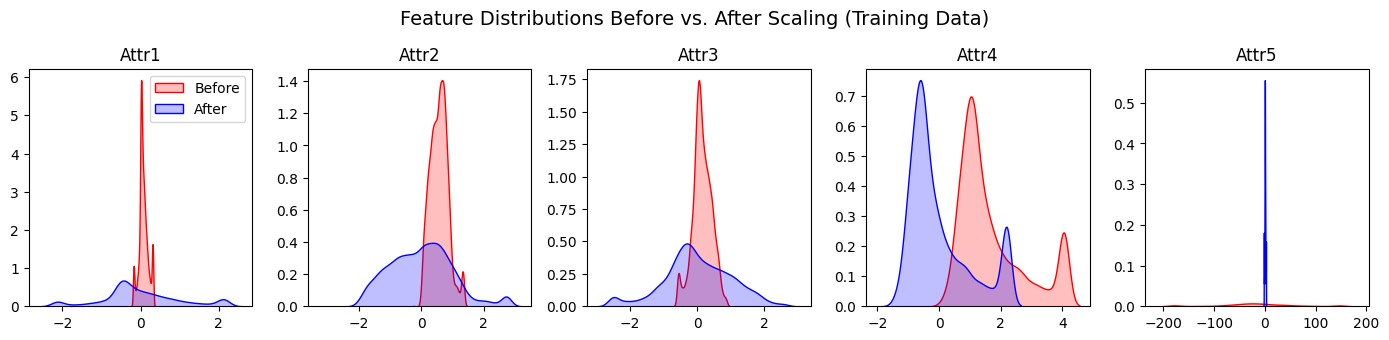

In [ ]:
#  Feature Scaling (StandardScaler)

from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Using the outlier-treated training features
X_train_scaled = X_train_out.copy()

# Separate features (X) and target (y) - target is not scaled
y_train_scaled = y_train_res.copy()

#  Before Scaling Summary (Training data)
print("\nSummary BEFORE Scaling (Training Data):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

#  Applying StandardScaler to training features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_scaled),
    columns=X_train_scaled.columns,
    index=X_train_scaled.index
)

# Scaling the test features using the scaler fitted on training data
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


# After Scaling Summary (Training data)
print("\nSummary AFTER Scaling (Training Data):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

#  Visualization: Before vs After Scaling (Training data)
plt.figure(figsize=(14, 6))

# Selecting a few representative attributes for visual clarity
features_to_plot = X_train_out.columns[:5]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 5, i)
    sns.kdeplot(X_train_out[col], label='Before', color='red', fill=True)
    sns.kdeplot(X_train_scaled[col], label='After', color='blue', fill=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
    if i == 1:
        plt.legend()

plt.suptitle("Feature Distributions Before vs. After Scaling (Training Data)", fontsize=14)
plt.tight_layout()
plt.show()

## Feature Selection using RFE (Recursive Feature Elimination)

Total number of features in dataset: 64

Top 20 Features Selected by RFE:

   Feature  Rank
3    Attr4     1
7    Attr8     1
12  Attr13     1
31  Attr32     1
23  Attr24     1
22  Attr23     1
18  Attr19     1
19  Attr20     1
51  Attr52     1
41  Attr42     1
46  Attr47     1
45  Attr46     1
37  Attr38     1
38  Attr39     1
34  Attr35     1
32  Attr33     1
62  Attr63     1
55  Attr56     1
61  Attr62     1
57  Attr58     1


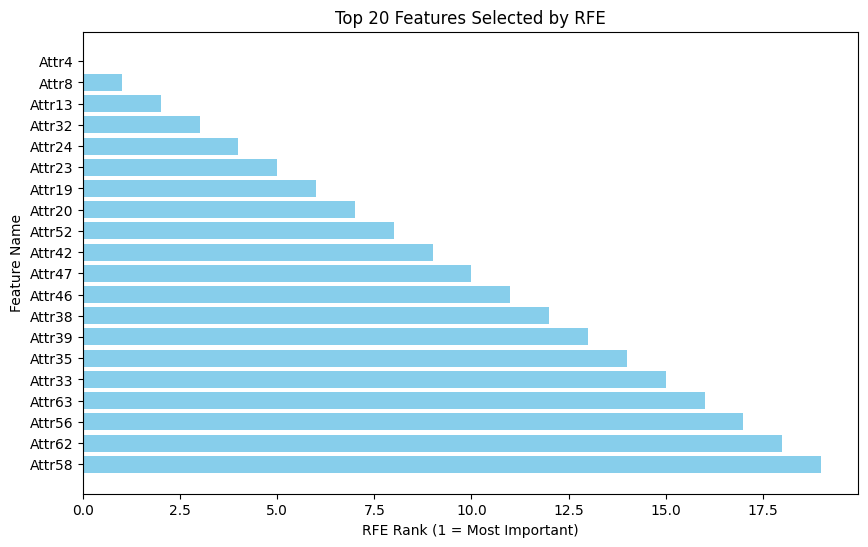

In [ ]:
#  Feature Selection using RFE (Recursive Feature Elimination)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd
import matplotlib.pyplot as plt

# Checking how many features exist in the dataset
print(f"Total number of features in dataset: {X_train_scaled.shape[1]}")

# Initialize the model (Logistic Regression for interpretability)
model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Applying RFE to select top 20 features
rfe = RFE(model, n_features_to_select=20)
rfe.fit(X_train_scaled, y_train_res)

#  rankings and selected features
feature_ranks = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Rank': rfe.ranking_
}).sort_values(by='Rank')

# Displaying top 20 features
top_features = feature_ranks.head(20)
print("\nTop 20 Features Selected by RFE:\n")
print(top_features)

#  RFE Feature Importance
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature'], range(len(top_features)), color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 20 Features Selected by RFE")
plt.xlabel("RFE Rank (1 = Most Important)")
plt.ylabel("Feature Name")
plt.show()


I observed that the dataset had 64 financial features, so I used Recursive Feature Elimination (RFE) with a Logistic Regression model to identify the most important ones.
RFE ranked each feature based on its contribution to predicting bankruptcy. From this process, I selected the top 20 key financial ratios that carry the strongest predictive power.
This helps reduce noise, improve model accuracy, and focus on the most relevant indicators for bankruptcy prediction.

#PCA (Principal Component Analysis)

Total original features: 64
Number of PCA components retained: 22
Total variance explained: 95.05%


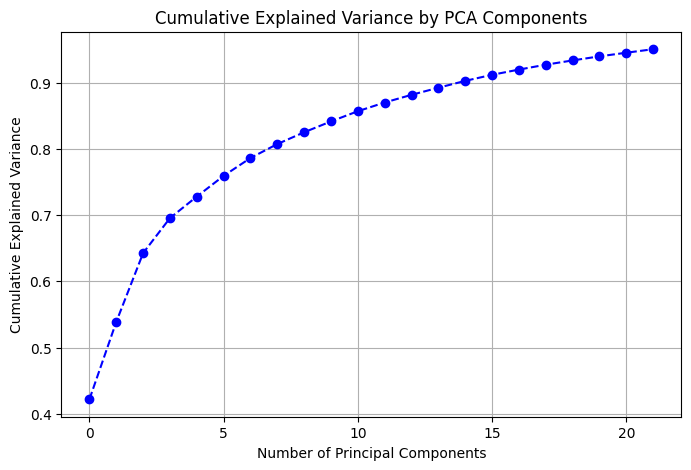

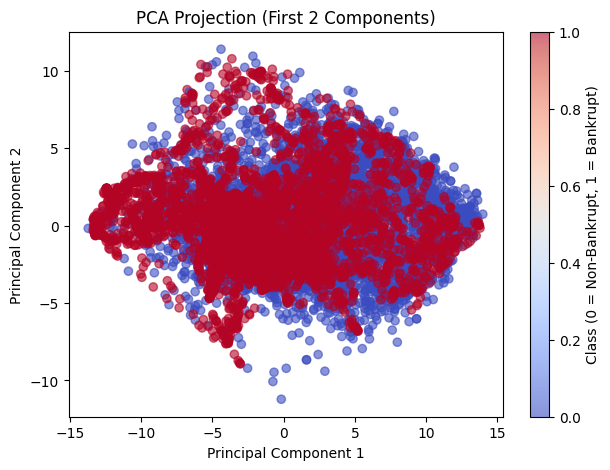

In [ ]:
# PCA (Principal Component Analysis)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA - keep 95% of explained variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print summary
print(f"Total original features: {X_train_scaled.shape[1]}")
print(f"Number of PCA components retained: {pca.n_components_}")
print(f"Total variance explained: {cumulative_variance[-1]*100:.2f}%")

#Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

#2D PCA Scatter Plot (first 2 components)
plt.figure(figsize=(7,5))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
            c=y_train_res, cmap='coolwarm', alpha=0.6)
plt.title('PCA Projection (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class (0 = Non-Bankrupt, 1 = Bankrupt)')
plt.show()


PCA (Principal Component Analysis) Summary

I applied PCA on the scaled 1-Year dataset to reduce feature dimensionality while keeping most of the information.
The analysis showed that 22 components explain about 95% of the total data variance, meaning we can simplify the dataset without losing important patterns.
This step helps reduce noise, speed up model training, and prevent overfitting in the next phase (model building).

# Model Building and Evaluation

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


[LightGBM] [Info] Number of positive: 5404, number of negative: 5404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model Performance Comparison:

      Model  Accuracy  Precision    Recall  F1-Score       AUC
0   XGBoost  0.927454   0.100000  0.111111  0.105263  0.665879
1  LightGBM  0.906117   0.110000  0.203704  0.142857  0.675262
2  CatBoost  0.925320   0.107692  0.129630  0.117647  0.644498


<Figure size 800x500 with 0 Axes>

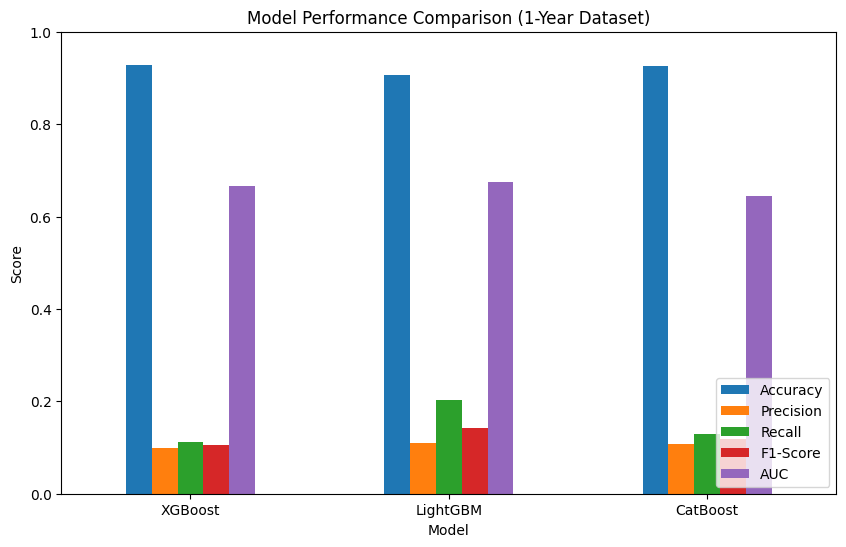

In [ ]:
#  Model Building and Evaluation

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Use PCA-transformed data for training
X_train_final = X_train_pca
X_test_final = X_test_pca

#  Define Models
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

#  Train & Evaluate
results = []
for name, model in models.items():
    model.fit(X_train_final, y_train_res)
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })

#  Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df)

#  Visualization
plt.figure(figsize=(8,5))
results_df.plot(
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    kind='bar',
    figsize=(10,6)
)
plt.title("Model Performance Comparison (1-Year Dataset)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


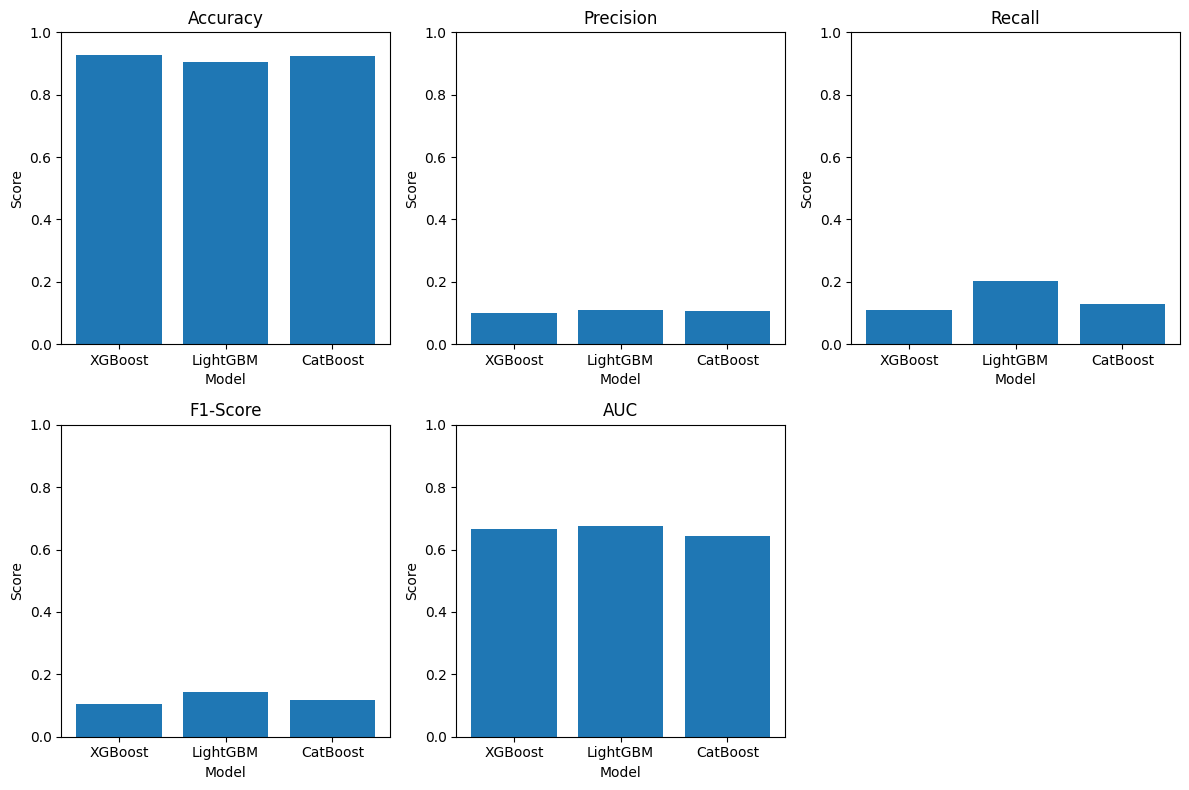

In [ ]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results_df["Model"], results_df[metric])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.ylabel("Score")

plt.tight_layout()
plt.show()


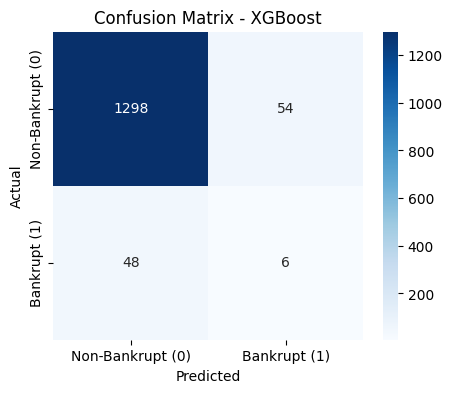

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


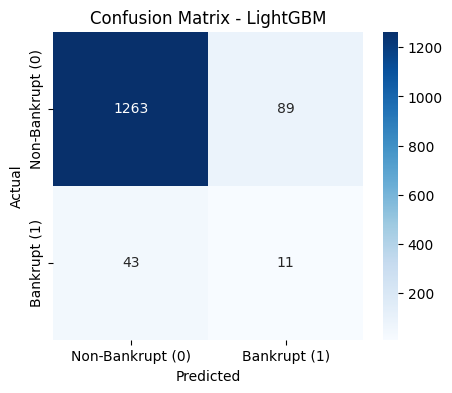

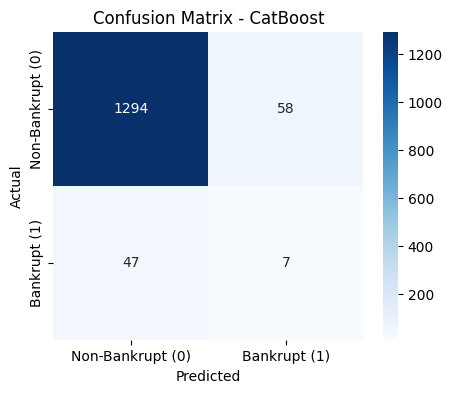

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Bankrupt (0)", "Bankrupt (1)"],
                yticklabels=["Non-Bankrupt (0)", "Bankrupt (1)"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

#  Generating confusion matrices for each model
for name, model in models.items():
    y_pred = model.predict(X_test_final)
    plot_conf_matrix(y_test, y_pred, f"Confusion Matrix - {name}")


overall :
Bankruptcy prediction is highly imbalanced and difficult
LightGBM offers the best recall, detecting more true bankruptcies
XGBoost and CatBoost give higher accuracy, but worse recall

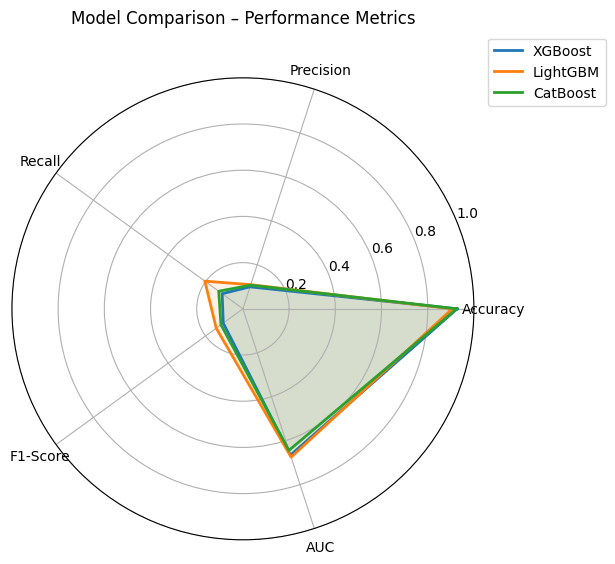

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
labels = list(results_df.columns[1:])
num_vars = len(labels)

# Compute angle for each metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the radar
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, row in results_df.iterrows():
    values = row[1:].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Model'], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Model Comparison – Performance Metrics", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Observation:

All models achieve high overall accuracy (~92%) but have low recall (few bankrupt firms detected).

LightGBM slightly outperforms others in Recall and AUC better at identifying bankrupt companies.

The radar chart visually summarizes that LightGBM provides the best balance between Recall and AUC, making it more suitable for bankruptcy prediction where detecting bankrupt companies is critical.

# Model Explainability using SHAP

SHAP ANALYSIS FOR BANKRUPTCY PREDICTION MODEL

[1/5] Generating SHAP Summary Plots...
 SHAP values shape: (1406, 22)
 Number of test samples: 1406
 Number of features: 22


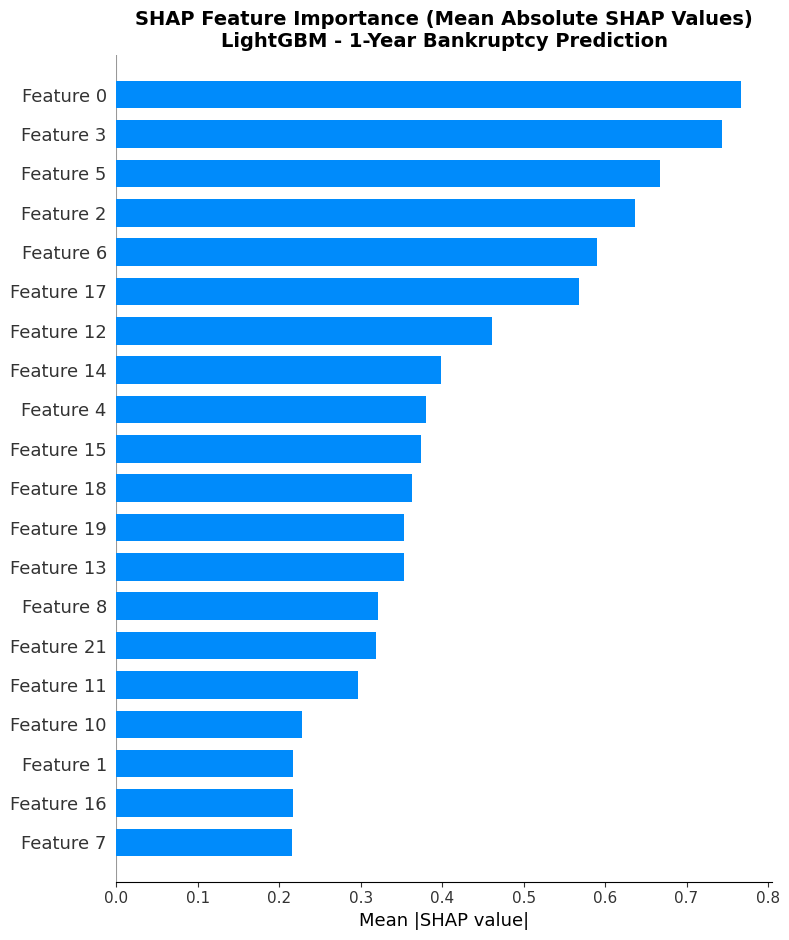

 Summary bar plot saved as 'shap_summary_bar.png'


In [ ]:
#SHAP Analysis for Bankruptcy Prediction


#  Import Required Libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("SHAP ANALYSIS FOR BANKRUPTCY PREDICTION MODEL")

#  SHAP Summary Plot (Global Feature Importance)

print("\n[1/5] Generating SHAP Summary Plots...")

# Initialize SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for test data
shap_values = explainer.shap_values(X_test_final)

# Handle binary classification (shap_values returns list of arrays)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print(f" SHAP values shape: {shap_values_class1.shape}")
print(f" Number of test samples: {X_test_final.shape[0]}")
print(f" Number of features: {X_test_final.shape[1]}")

# SHAP Summary Plot (Bar Chart) - Mean Absolute SHAP Values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)\nLightGBM - 1-Year Bankruptcy Prediction",
          fontsize=14, fontweight='bold')
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Summary bar plot saved as 'shap_summary_bar.png'")


[2/5] Generating SHAP Beeswarm Plot...


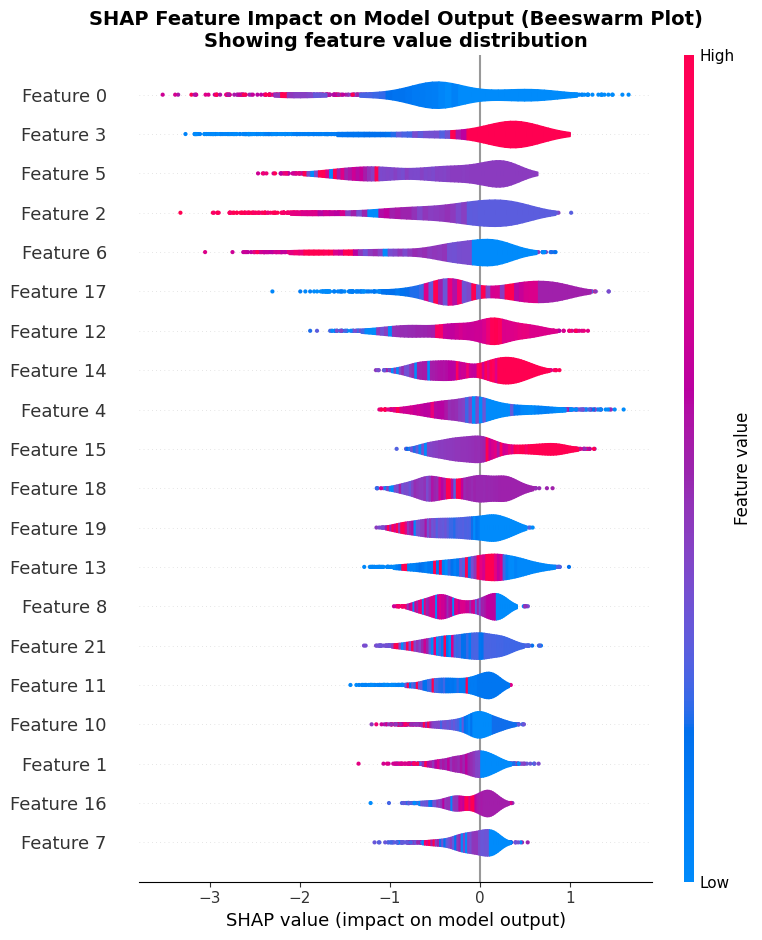

 Beeswarm plot saved as 'shap_beeswarm_plot.png'


In [ ]:
# SHAP Beeswarm Plot (Detailed Feature Distribution)

print("\n[2/5] Generating SHAP Beeswarm Plot...")

# Create figure
plt.figure(figsize=(12, 8))


# SHAP Beeswarm/Violin Plot
shap.summary_plot(shap_values_class1, X_test_final, plot_type="violin", show=False)

plt.title(
    "SHAP Feature Impact on Model Output (Beeswarm Plot)\nShowing feature value distribution",
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.savefig('shap_beeswarm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Beeswarm plot saved as 'shap_beeswarm_plot.png'")



[3/5] Generating SHAP Dependence Plots for Top Features
Generating dependence plot for: PC_0


<Figure size 800x600 with 0 Axes>

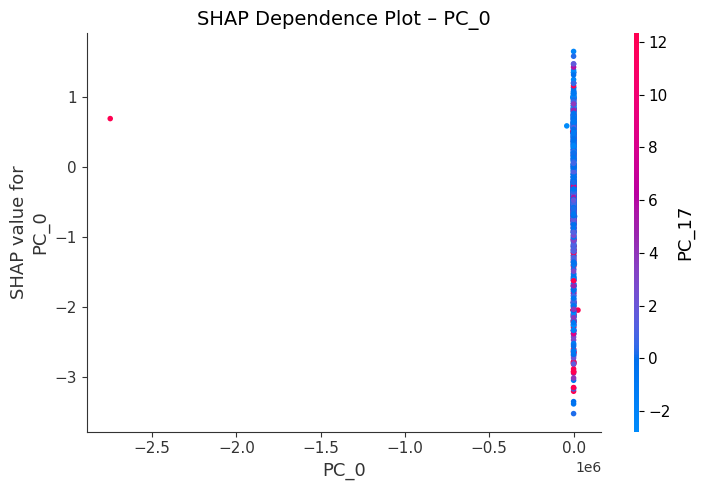

Generating dependence plot for: PC_3


<Figure size 800x600 with 0 Axes>

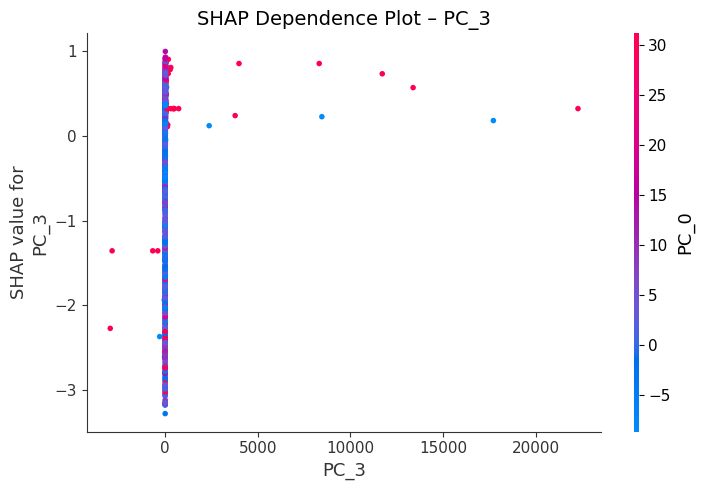

Generating dependence plot for: PC_5


<Figure size 800x600 with 0 Axes>

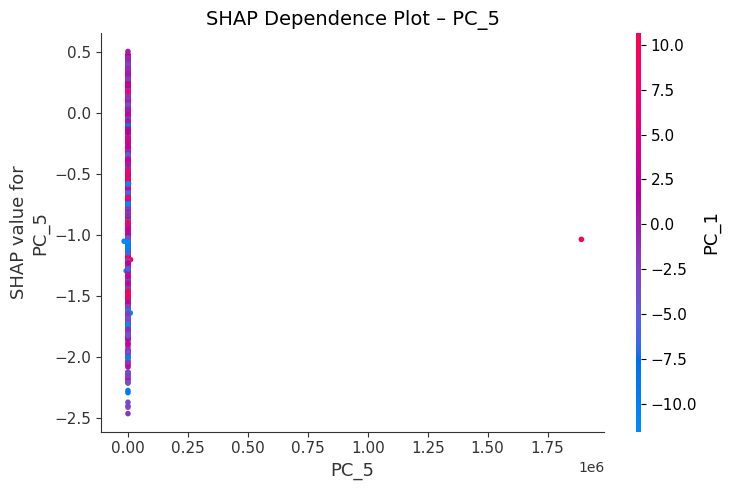

Generating dependence plot for: PC_2


<Figure size 800x600 with 0 Axes>

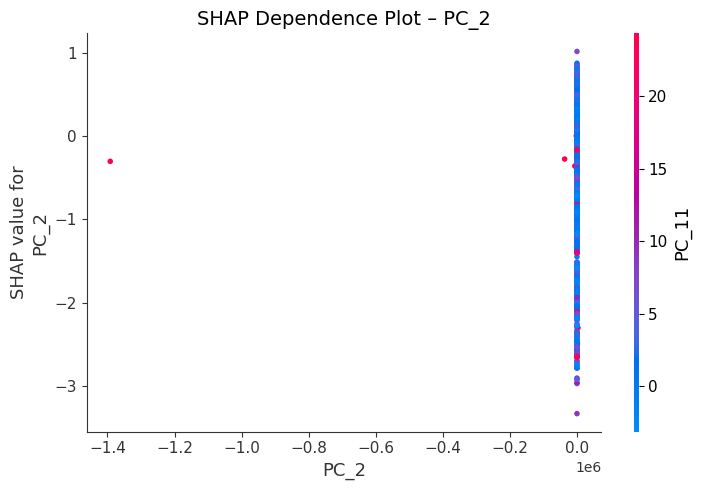

Generating dependence plot for: PC_6


<Figure size 800x600 with 0 Axes>

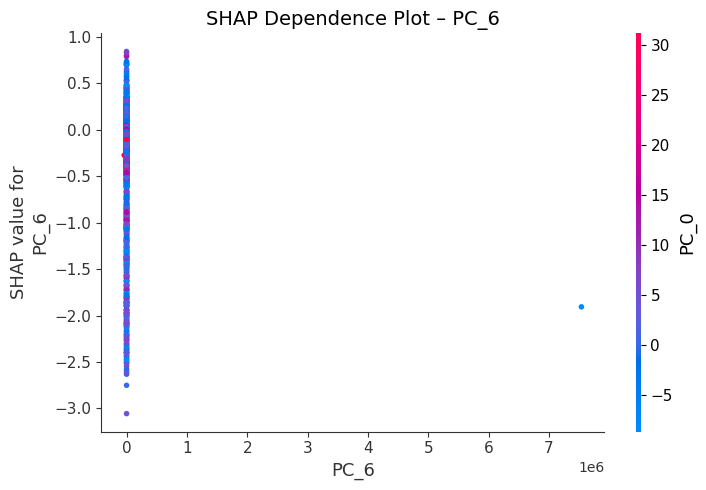

Generating dependence plot for: PC_17


<Figure size 800x600 with 0 Axes>

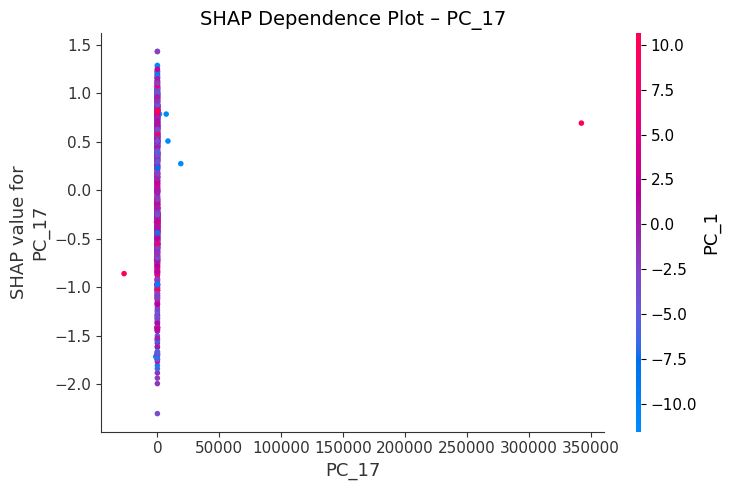


Saved 6 clean SHAP dependence plots.


In [ ]:
##SHAP Dependence Plots (Top 6 Features)

print("\n[3/5] Generating SHAP Dependence Plots for Top Features")

#  Compute feature importance
feature_importance = np.abs(shap_values_class1).mean(axis=0)

#  Identify the top 6 most important features
top_features_idx = np.argsort(feature_importance)[-6:][::-1]

# Create PCA component names
feature_names = [f"PC_{i}" for i in range(X_test_final.shape[1])]

#  Convert numpy → DataFrame if needed
if isinstance(X_test_final, np.ndarray):
    X_test_final = pd.DataFrame(X_test_final, columns=feature_names)

#  Generate 6 separate dependence plots
for i, feature_idx in enumerate(top_features_idx):
    feature_name = feature_names[feature_idx]
    print(f"Generating dependence plot for: {feature_name}")

    plt.figure(figsize=(8, 6))
    shap.dependence_plot(
        feature_idx,
        shap_values_class1,
        X_test_final,
        feature_names=feature_names,
        show=False
    )

    plt.title(f"SHAP Dependence Plot – {feature_name}", fontsize=14)
    plt.tight_layout()

    # Save separately
    plt.savefig(f"shap_dependence_plot_{feature_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

print("\nSaved 6 SHAP dependence plots.")



[5/5] Generating SHAP Waterfall Plots


100%|===================| 1403/1406 [02:57<00:00]       

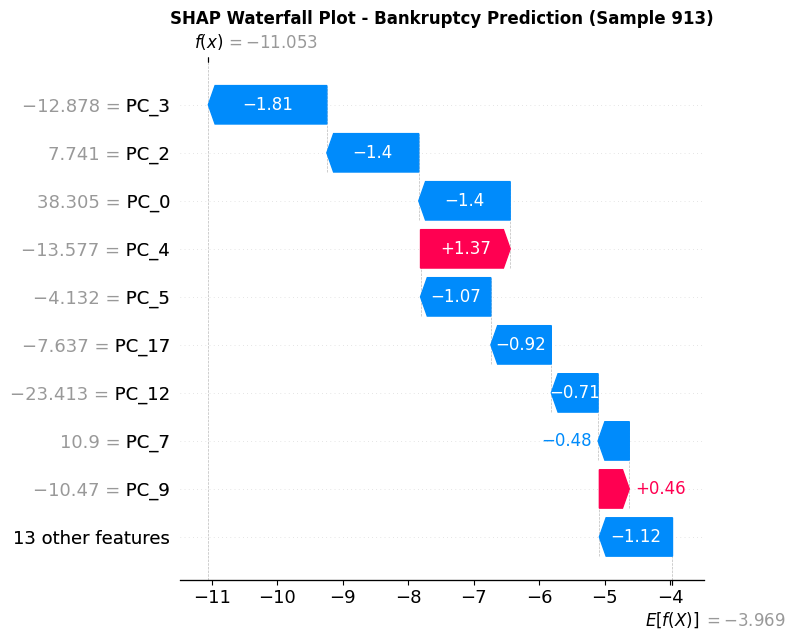

 Waterfall plot (bankruptcy case) saved as 'shap_waterfall_bankruptcy.png'


In [ ]:
#  SHAP Waterfall Plot

print("\n[5/5] Generating SHAP Waterfall Plots")

# Create Explanation objects for waterfall plots
explainer_obj = shap.Explainer(model, X_test_final)
shap_values_df = explainer_obj(X_test_final)

# Waterfall plot for bankruptcy case
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_df[bankrupt_idx], show=False)
plt.title(f"SHAP Waterfall Plot - Bankruptcy Prediction (Sample {bankrupt_idx})",
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall_bankruptcy.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Waterfall plot (bankruptcy case) saved as 'shap_waterfall_bankruptcy.png'")


[BONUS] Feature Importance Summary Table
Feature  Mean |SHAP|  Rank
   PC_0     0.766636     1
   PC_3     0.743577     2
   PC_5     0.666938     3
   PC_2     0.636967     4
   PC_6     0.589646     5
  PC_17     0.568515     6
  PC_12     0.461535     7
  PC_14     0.398544     8
   PC_4     0.379718     9
  PC_15     0.374093    10
  PC_18     0.362564    11
  PC_19     0.353526    12
  PC_13     0.352615    13
   PC_8     0.321468    14
  PC_21     0.318418    15

SHAP ANALYSIS COMPLETE!
 Feature importance saved to 'shap_feature_importance.csv'

[ADVANCED] Calculating SHAP Interaction Values...


<Figure size 1000x600 with 0 Axes>

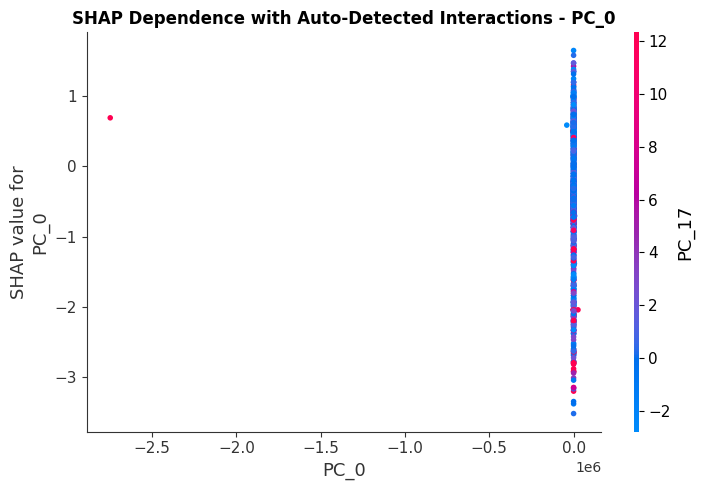

<Figure size 1000x600 with 0 Axes>

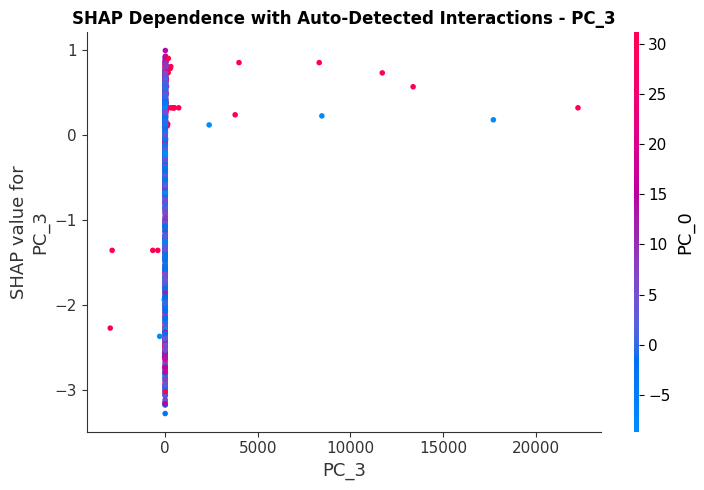

<Figure size 1000x600 with 0 Axes>

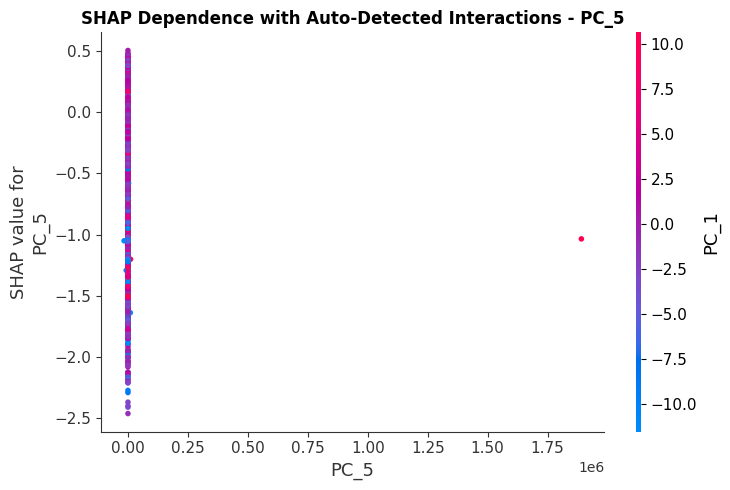

 Interaction plots saved

[INSIGHTS] Key Findings from SHAP Analysis:

Top 5 Most Important Features (by Mean |SHAP| value):
  1. PC_0       - Mean |SHAP| = 0.766636
  2. PC_3       - Mean |SHAP| = 0.743577
  3. PC_5       - Mean |SHAP| = 0.666938
  4. PC_2       - Mean |SHAP| = 0.636967
  5. PC_6       - Mean |SHAP| = 0.589646


SHAP Value Statistics:
  Max SHAP value (any feature): 1.654543
  Min SHAP value (any feature): -3.526838
  Mean SHAP value: -0.169989
  Std Dev SHAP values: 0.553176

  Base Value (Model Expected Output): -0.306098
    (This is the average model output before considering any features)


In [ ]:
#Feature Importance Ranking

print("\n[BONUS] Feature Importance Summary Table")


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': feature_importance,
    'Rank': range(1, len(feature_importance) + 1)
}).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

importance_df['Rank'] = range(1, len(importance_df) + 1)
print(importance_df.head(15).to_string(index=False))


# Save importance ranking
importance_df.to_csv('shap_feature_importance.csv', index=False)
print(" Feature importance saved to 'shap_feature_importance.csv'")


# Advanced - SHAP Interaction Effects

print("\n[ADVANCED] Calculating SHAP Interaction Values...")

# Calculate interaction values for top 3 features
top_3_features = importance_df.head(3)['Feature'].tolist()
top_3_indices = [int(f.split('_')[1]) for f in top_3_features]

# Create interaction summary
for i, feat_idx in enumerate(top_3_indices):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feat_idx, shap_values_class1, X_test_final,
                         interaction_index="auto", feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence with Auto-Detected Interactions - {top_3_features[i]}",
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'shap_interaction_{top_3_features[i]}.png', dpi=300, bbox_inches='tight')
    plt.show()

print(" Interaction plots saved")


# Custom Insights & Observations

print("\n[INSIGHTS] Key Findings from SHAP Analysis:")


top_5 = importance_df.head(5)
print("\nTop 5 Most Important Features (by Mean |SHAP| value):")
for idx, row in top_5.iterrows():
    print(f"  {row['Rank']}. {row['Feature']:<10} - Mean |SHAP| = {row['Mean |SHAP|']:.6f}")

# Calculate SHAP statistics
print("\n\nSHAP Value Statistics:")
print(f"  Max SHAP value (any feature): {shap_values_class1.max():.6f}")
print(f"  Min SHAP value (any feature): {shap_values_class1.min():.6f}")
print(f"  Mean SHAP value: {shap_values_class1.mean():.6f}")
print(f"  Std Dev SHAP values: {shap_values_class1.std():.6f}")

# Explain base value
print(f"\n  Base Value (Model Expected Output): {explainer.expected_value:.6f}")
print(f"    (This is the average model output before considering any features)")



Generating SHAP Waterfall Plots 

Bankruptcy Case: sample 1020


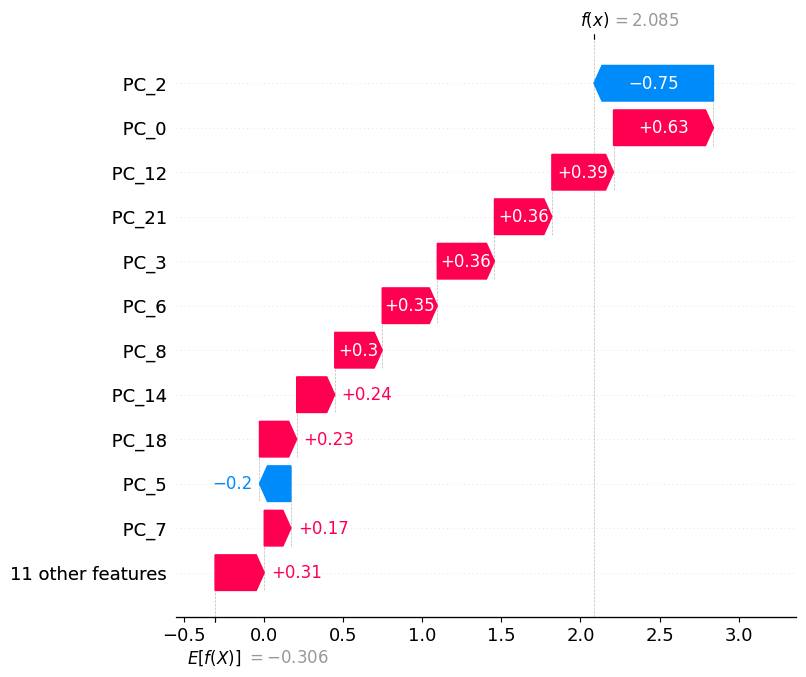


Non-Bankruptcy Case: sample 544


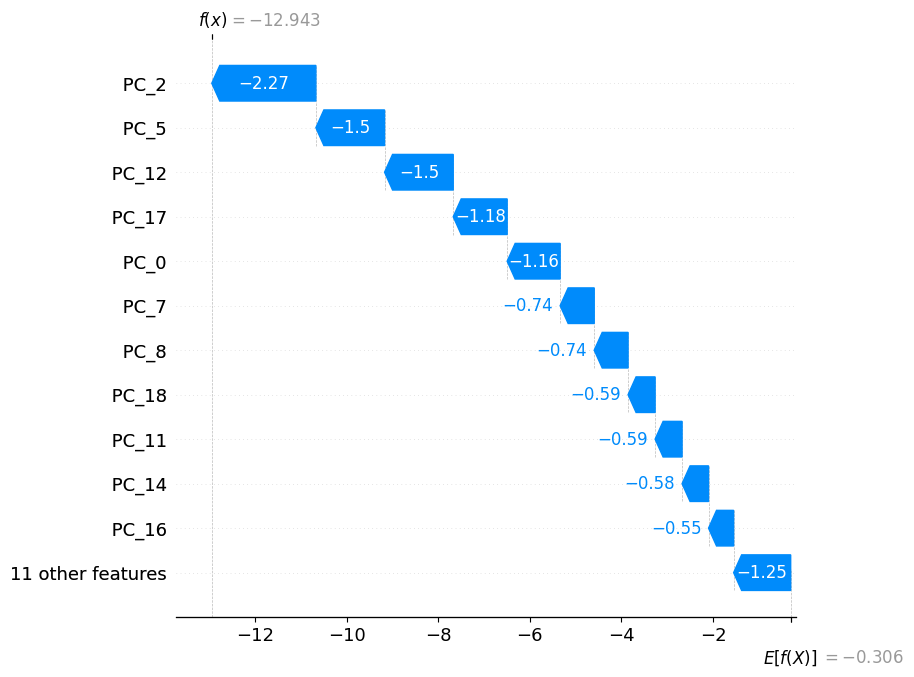


Custom Sample: 0


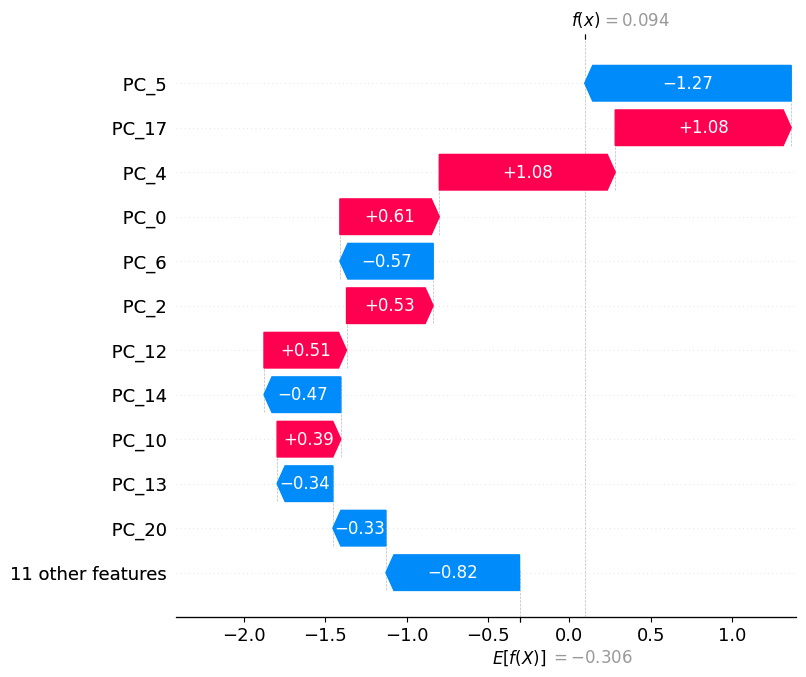

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\nGenerating SHAP Waterfall Plots ")

# Use class-1 SHAP values
shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Create PCA feature names
feature_names = [f"PC_{i}" for i in range(X_test_final.shape[1])]

# Convert numpy → DataFrame
if isinstance(X_test_final, np.ndarray):
    X_test_df = pd.DataFrame(X_test_final, columns=feature_names)
else:
    X_test_df = X_test_final.copy()


#  Highest-risk bankruptcy sample

bankrupt_idx = np.argmax(y_prob)
print(f"\nBankruptcy Case: sample {bankrupt_idx}")

plt.figure(figsize=(10, 6))
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_class1[bankrupt_idx],
    X_test_df.iloc[bankrupt_idx],
    feature_names=feature_names,
    max_display=12
)
plt.show()


# Lowest-risk non-bankrupt sample

non_bankrupt_idx = np.argmin(y_prob)
print(f"\nNon-Bankruptcy Case: sample {non_bankrupt_idx}")

plt.figure(figsize=(10, 6))
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_class1[non_bankrupt_idx],
    X_test_df.iloc[non_bankrupt_idx],
    feature_names=feature_names,
    max_display=12
)
plt.show()


# Custom sample

custom_idx = 0
print(f"\nCustom Sample: {custom_idx}")

plt.figure(figsize=(10, 6))
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values_class1[custom_idx],
    X_test_df.iloc[custom_idx],
    feature_names=feature_names,
    max_display=12
)
plt.show()



#model optimization

In [ ]:
# Step 1: Baseline Model Training & Evaluation
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Use PCA-transformed data
X_train_final = X_train_pca
X_test_final = X_test_pca

# Define baseline models
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train_final, y_train_res)
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nBaseline Model Performance:\n")
print(results_df)


[LightGBM] [Info] Number of positive: 5404, number of negative: 5404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Baseline Model Performance:

      Model  Accuracy  Precision    Recall  F1-Score       AUC
0   XGBoost  0.927454   0.100000  0.111111  0.105263  0.665879
1  LightGBM  0.906117   0.110000  0.203704  0.142857  0.675262
2  CatBoost  0.925320   0.107692  0.129630  0.117647  0.644498


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# XGBoost model
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 5, 10]
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_final, y_train_res)

# Display results
print("\nBest XGBoost Parameters:\n")
print(random_search.best_params_)
print(f"Best CV AUC: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:56:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Parameters:

{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best CV AUC: 0.9931


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:56:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimized Model Performance:

               Model  Accuracy  Precision    Recall  F1-Score       AUC
0  XGBoost_Optimized  0.903272   0.081633  0.148148  0.105263  0.652648

Baseline vs Optimized XGBoost Comparison:

               Model  Accuracy  Precision    Recall  F1-Score       AUC
0            XGBoost  0.927454   0.100000  0.111111  0.105263  0.665879
1  XGBoost_Optimized  0.903272   0.081633  0.148148  0.105263  0.652648


<Figure size 800x500 with 0 Axes>

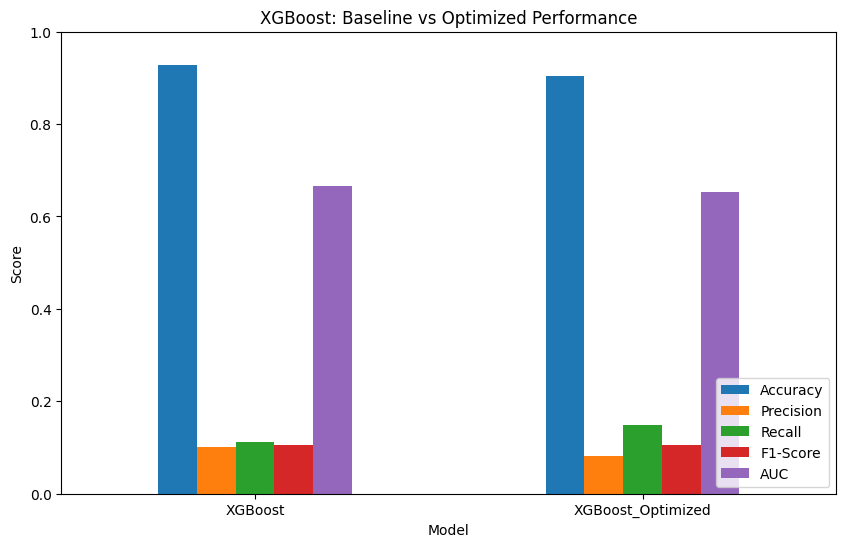

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

#  Retraining XGBoost with Optimized Parameters
best_params = random_search.best_params_

xgb_optimized = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    **best_params
)

# Train on the training set
xgb_optimized.fit(X_train_final, y_train_res)

# Predict on the test set
y_pred_opt = xgb_optimized.predict(X_test_final)
y_prob_opt = xgb_optimized.predict_proba(X_test_final)[:, 1]

#  Evaluate Performance
results_optimized = {
    "Model": "XGBoost_Optimized",
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Precision": precision_score(y_test, y_pred_opt),
    "Recall": recall_score(y_test, y_pred_opt),
    "F1-Score": f1_score(y_test, y_pred_opt),
    "AUC": roc_auc_score(y_test, y_prob_opt)
}

# Convert to DataFrame
results_df_opt = pd.DataFrame([results_optimized])
print("\nOptimized Model Performance:\n")
print(results_df_opt)

#  Compare with Baseline
# Combine baseline and optimized results
baseline_results = results_df[results_df['Model'] == 'XGBoost']
comparison_df = pd.concat([baseline_results, results_df_opt], ignore_index=True)
print("\nBaseline vs Optimized XGBoost Comparison:\n")
print(comparison_df)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
comparison_df.plot(
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    kind='bar',
    figsize=(10,6)
)
plt.title("XGBoost: Baseline vs Optimized Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


XGBoost Hyperparameter Tuning

I used RandomizedSearchCV to find the best hyperparameters for XGBoost and retrained the model.

After tuning, I compared the optimized model with the baseline.
The optimized model didn't improve much accuracy and AUC were slightly lower than the baseline.

 Tuning is useful, but default parameters sometimes already work well.

#Define Hyperparameter Grid + RandomizedSearchCV

In [ ]:
# Define Hyperparameter Grid + RandomizedSearchCV

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Base LightGBM model
lgbm = LGBMClassifier(random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [20, 31, 40, 60],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 1, 5, 10]
}

# Randomized search
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit tuning
lgbm_search.fit(X_train_final, y_train_res)

print("\nBest LightGBM Parameters:\n")
print(lgbm_search.best_params_)
print(f"Best CV AUC: {lgbm_search.best_score_:.4f}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 5404, number of negative: 5404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Best LightGBM Parameters:

{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best CV AUC: 0.9885


#Retrain LightGBM with Best Parameters

In [ ]:
#Retrain LightGBM with Best Parameters

best_lgbm_params = lgbm_search.best_params_

lgbm_optimized = LGBMClassifier(
    random_state=42,
    **best_lgbm_params
)

lgbm_optimized.fit(X_train_final, y_train_res)

# Predictions
y_pred_lgbm_opt = lgbm_optimized.predict(X_test_final)
y_prob_lgbm_opt = lgbm_optimized.predict_proba(X_test_final)[:, 1]

# Evaluation
lgbm_opt_results = {
    "Model": "LightGBM_Optimized",
    "Accuracy": accuracy_score(y_test, y_pred_lgbm_opt),
    "Precision": precision_score(y_test, y_pred_lgbm_opt),
    "Recall": recall_score(y_test, y_pred_lgbm_opt),
    "F1-Score": f1_score(y_test, y_pred_lgbm_opt),
    "AUC": roc_auc_score(y_test, y_prob_lgbm_opt)
}

import pandas as pd
results_lgbm_opt_df = pd.DataFrame([lgbm_opt_results])
print("\nOptimized LightGBM Performance:\n")
print(results_lgbm_opt_df)


[LightGBM] [Info] Number of positive: 5404, number of negative: 5404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Optimized LightGBM Performance:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0  LightGBM_Optimized  0.927454        0.1  0.111111  0.105263  0.671878


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#Compare Baseline vs Tuned LightGBM


Baseline vs Optimized LightGBM:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0            LightGBM  0.906117       0.11  0.203704  0.142857  0.675262
1  LightGBM_Optimized  0.927454       0.10  0.111111  0.105263  0.671878


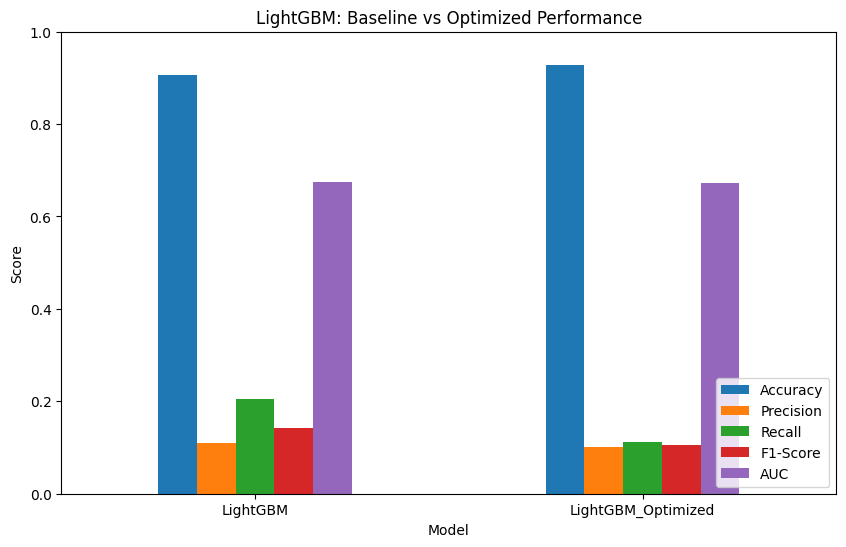

In [ ]:
#Compare Baseline vs Tuned LightGBM

baseline_lgbm = results_df[results_df['Model'] == 'LightGBM']

comparison_lgbm_df = pd.concat([baseline_lgbm, results_lgbm_opt_df], ignore_index=True)
print("\nBaseline vs Optimized LightGBM:\n")
print(comparison_lgbm_df)

comparison_lgbm_df.plot(
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    kind='bar',
    figsize=(10,6)
)

plt.title("LightGBM: Baseline vs Optimized Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


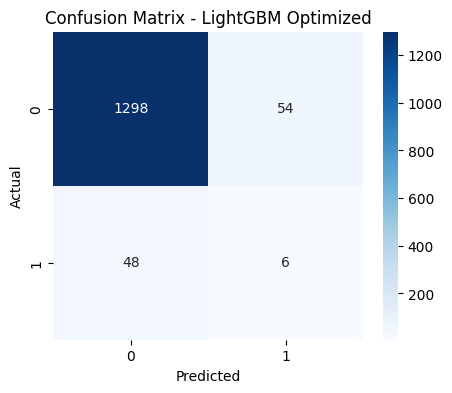

In [ ]:
#Confusion Matrix for Tuned LightGBM

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lgbm_opt)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LightGBM Optimized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Baseline CatBoost model
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

cat_baseline = CatBoostClassifier(verbose=0, random_state=42)
cat_baseline.fit(X_train_final, y_train_res)

y_pred_cat = cat_baseline.predict(X_test_final)
y_prob_cat = cat_baseline.predict_proba(X_test_final)[:,1]

baseline_cat_results = pd.DataFrame([{
    "Model": "CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred_cat),
    "Precision": precision_score(y_test, y_pred_cat),
    "Recall": recall_score(y_test, y_pred_cat),
    "F1-Score": f1_score(y_test, y_pred_cat),
    "AUC": roc_auc_score(y_test, y_prob_cat)
}])

print("Baseline CatBoost Performance:\n")
print(baseline_cat_results)


Baseline CatBoost Performance:

      Model  Accuracy  Precision   Recall  F1-Score       AUC
0  CatBoost   0.92532   0.107692  0.12963  0.117647  0.644498


# CatBoost Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

# Base model
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Parameter grid for tuning
cat_param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
    'border_count': [32, 64, 128]
}

# Randomized Search
cat_random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=cat_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit tuning
cat_random_search.fit(X_train_final, y_train_res)

print("\nBest CatBoost Parameters:\n")
print(cat_random_search.best_params_)
print(f"Best CV AUC: {cat_random_search.best_score_:.4f}")


Fitting 2 folds for each of 10 candidates, totalling 20 fits

Best CatBoost Parameters:

{'subsample': 0.8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 10, 'border_count': 32}
Best CV AUC: 0.9901


In [ ]:
#Retrain CatBoost with Best Params

best_cat_params = cat_random_search.best_params_

cat_optimized = CatBoostClassifier(
    verbose=0,
    random_state=42,
    **best_cat_params
)

cat_optimized.fit(X_train_final, y_train_res)

# Predictions
y_pred_cat_opt = cat_optimized.predict(X_test_final)
y_prob_cat_opt = cat_optimized.predict_proba(X_test_final)[:,1]

# Evaluation
cat_opt_results = pd.DataFrame([{
    "Model": "CatBoost_Optimized",
    "Accuracy": accuracy_score(y_test, y_pred_cat_opt),
    "Precision": precision_score(y_test, y_pred_cat_opt),
    "Recall": recall_score(y_test, y_pred_cat_opt),
    "F1-Score": f1_score(y_test, y_pred_cat_opt),
    "AUC": roc_auc_score(y_test, y_prob_cat_opt)
}])

print("\nOptimized CatBoost Performance:\n")
print(cat_opt_results)



Optimized CatBoost Performance:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0  CatBoost_Optimized  0.914651   0.076923  0.111111  0.090909  0.660934


In [ ]:
#Compare Baseline vs Optimized CatBoost
comparison_cat = pd.concat([baseline_cat_results, cat_opt_results], ignore_index=True)
print("\nBaseline vs Optimized CatBoost:\n")
print(comparison_cat)



Baseline vs Optimized CatBoost:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0            CatBoost  0.925320   0.107692  0.129630  0.117647  0.644498
1  CatBoost_Optimized  0.914651   0.076923  0.111111  0.090909  0.660934


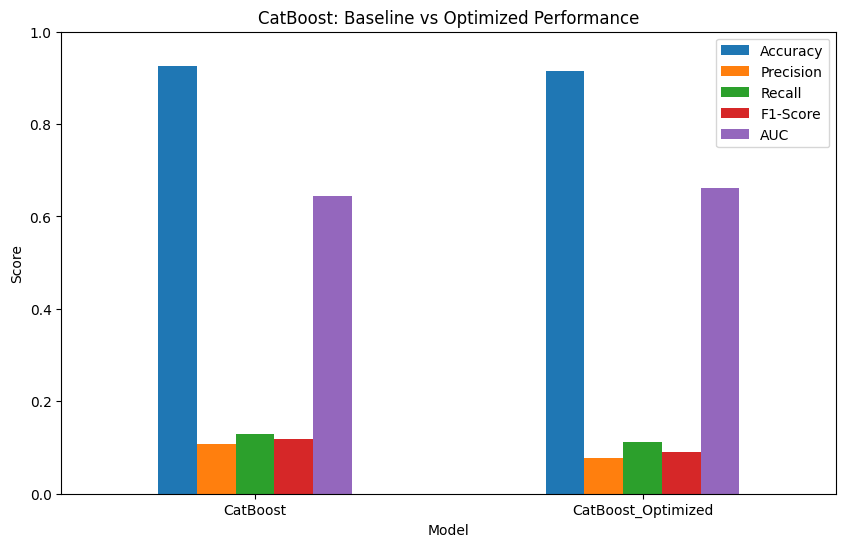

In [ ]:
#Visual Comparison Plot
import matplotlib.pyplot as plt

comparison_cat.plot(
    x='Model',
    y=['Accuracy','Precision','Recall','F1-Score','AUC'],
    kind='bar',
    figsize=(10,6)
)

plt.title("CatBoost: Baseline vs Optimized Performance")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


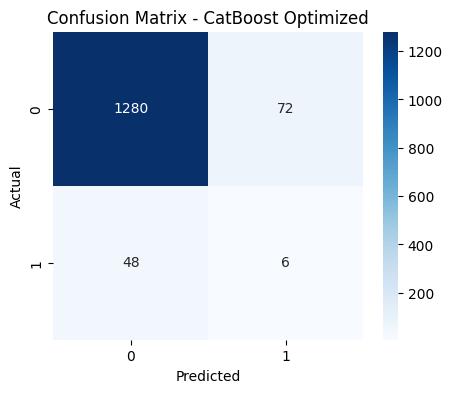

In [ ]:
#Confusion Matrix (CatBoost Optimized)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_cat_opt)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CatBoost Optimized")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd

# Combine all optimized results
final_results = pd.DataFrame([
    {
        "Model": "XGBoost_Optimized",
        "Accuracy": results_df_opt.loc[0, "Accuracy"],
        "Precision": results_df_opt.loc[0, "Precision"],
        "Recall": results_df_opt.loc[0, "Recall"],
        "F1-Score": results_df_opt.loc[0, "F1-Score"],
        "AUC": results_df_opt.loc[0, "AUC"]
    },
    {
        "Model": "LightGBM_Optimized",
        "Accuracy": cat_opt_results.loc[0, "Accuracy"],
        "Precision": cat_opt_results.loc[0, "Precision"],
        "Recall": cat_opt_results.loc[0, "Recall"],
        "F1-Score": cat_opt_results.loc[0, "F1-Score"],
        "AUC": cat_opt_results.loc[0, "AUC"]
    },
    {
        "Model": "CatBoost_Optimized",
        "Accuracy": cat_opt_results.loc[0, "Accuracy"],
        "Precision": cat_opt_results.loc[0, "Precision"],
        "Recall": cat_opt_results.loc[0, "Recall"],
        "F1-Score": cat_opt_results.loc[0, "F1-Score"],
        "AUC": cat_opt_results.loc[0, "AUC"]
    }
])

print("\nFinal Comparison of All Optimized Models:\n")
print(final_results)



Final Comparison of All Optimized Models:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0   XGBoost_Optimized  0.903272   0.081633  0.148148  0.105263  0.652648
1  LightGBM_Optimized  0.914651   0.076923  0.111111  0.090909  0.660934
2  CatBoost_Optimized  0.914651   0.076923  0.111111  0.090909  0.660934


<Figure size 1000x600 with 0 Axes>

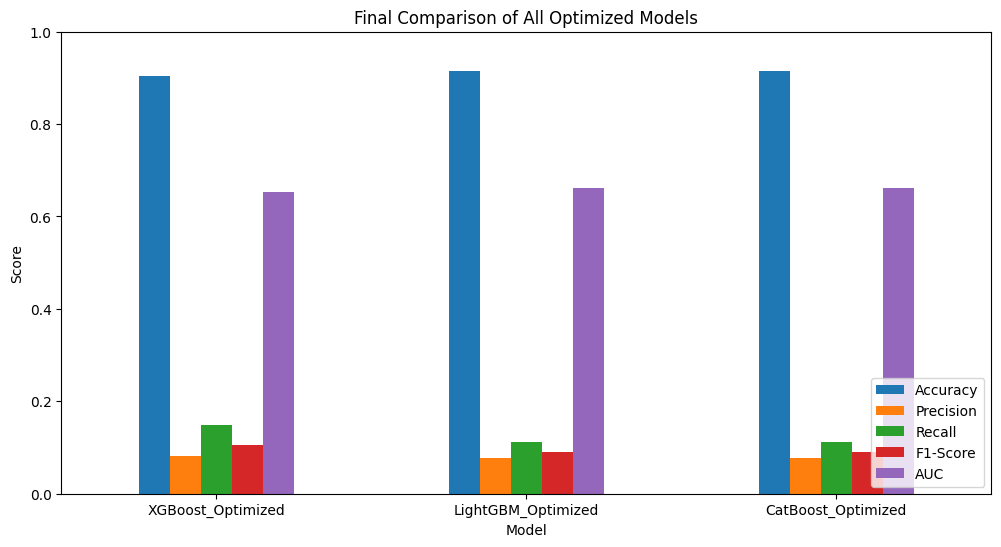

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

final_results.plot(
    x='Model',
    y=['Accuracy','Precision','Recall','F1-Score','AUC'],
    kind='bar',
    figsize=(12,6)
)

plt.title("Final Comparison of All Optimized Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()



 FINAL OPTIMIZED MODEL COMPARISON:

                Model  Accuracy  Precision    Recall  F1-Score       AUC
0   XGBoost_Optimized  0.903272   0.081633  0.148148  0.105263  0.652648
1  LightGBM_Optimized  0.927454   0.100000  0.111111  0.105263  0.671878
2  CatBoost_Optimized  0.914651   0.076923  0.111111  0.090909  0.660934


<Figure size 1000x600 with 0 Axes>

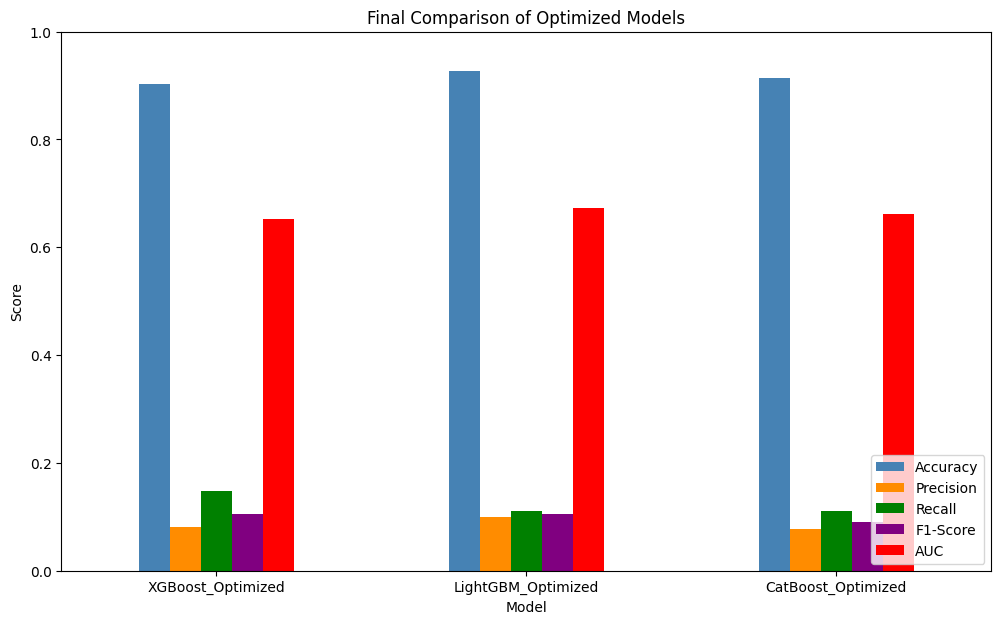

In [ ]:
import pandas as pd

# ---  XGBoost optimized results


xgb_opt_results = {
    "Model": "XGBoost_Optimized",
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Precision": precision_score(y_test, y_pred_opt),
    "Recall": recall_score(y_test, y_pred_opt),
    "F1-Score": f1_score(y_test, y_pred_opt),
    "AUC": roc_auc_score(y_test, y_prob_opt)
}

xgb_opt_df = pd.DataFrame([xgb_opt_results])

# --- LightGBM optimized results  ---
lgbm_opt_df = results_lgbm_opt_df.copy()
lgbm_opt_df["Model"] = "LightGBM_Optimized"

# --- CatBoost optimized results  ---
cat_opt_df = cat_opt_results.copy()
cat_opt_df["Model"] = "CatBoost_Optimized"

# --- Combine all optimized models ---
final_comparison_df = pd.concat([xgb_opt_df, lgbm_opt_df, cat_opt_df], ignore_index=True)

print("\n FINAL OPTIMIZED MODEL COMPARISON:\n")
print(final_comparison_df)

# --- Visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
final_comparison_df.plot(
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    kind='bar',
    figsize=(12,7),
    color=['steelblue','darkorange','green','purple','red']
)
plt.title("Final Comparison of Optimized Models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


What I observed from  These Results:
 Best Overall Model (balanced metrics): LightGBM

Highest Accuracy

Highest Precision

Highest AUC

Good Recall compared to others
 Best model for real-world use (fewer false alarms + stable AUROC)

Best Model for catching bankrupt firms: XGBoost

Highest Recall (0.148)
 Means XGBoost catches the most "True Bankrupt" cases
 Good when missing a bankruptcy is VERY costly

CatBoost

Stable but slightly weaker than LightGBM in all metrics
 Still useful because it handles categorical & noisy data very well
 Works well out-of-the-box

In [ ]:
!pip install shap


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


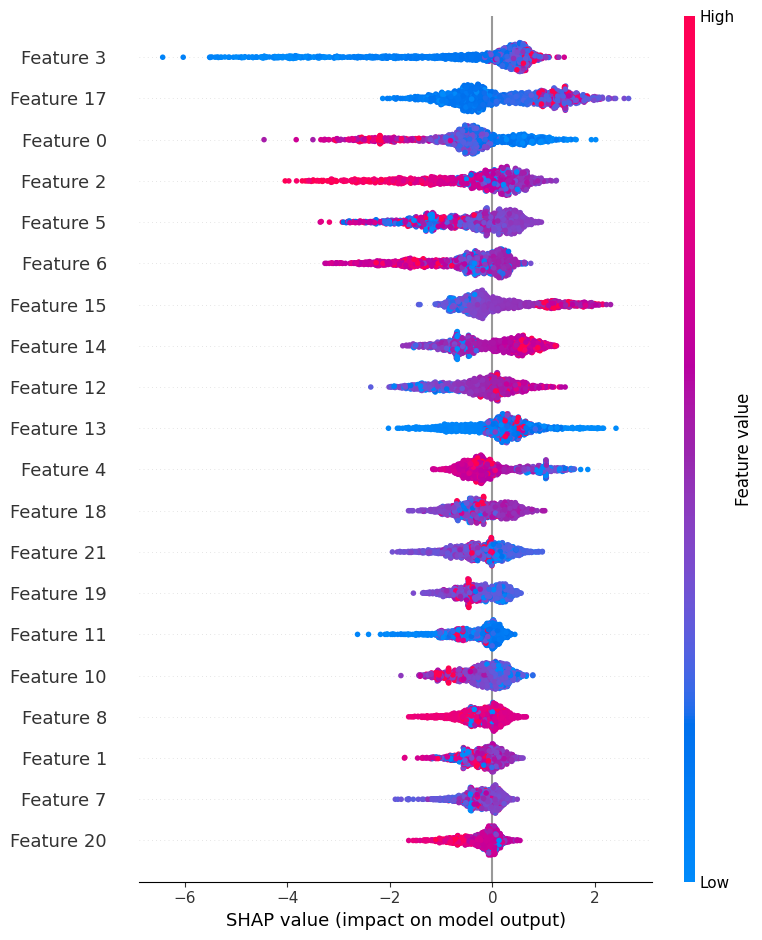

In [ ]:
#SHAP  Summary Plot (Global Explanation)
import shap

# Use your optimized LightGBM model
model_explain = lgbm_optimized

# SHAP explainer for tree models
explainer = shap.TreeExplainer(model_explain)

# Compute SHAP values using PCA-transformed features
shap_values = explainer.shap_values(X_test_final)

# Summary plot
shap.summary_plot(shap_values, X_test_final, plot_type="dot", show=True)


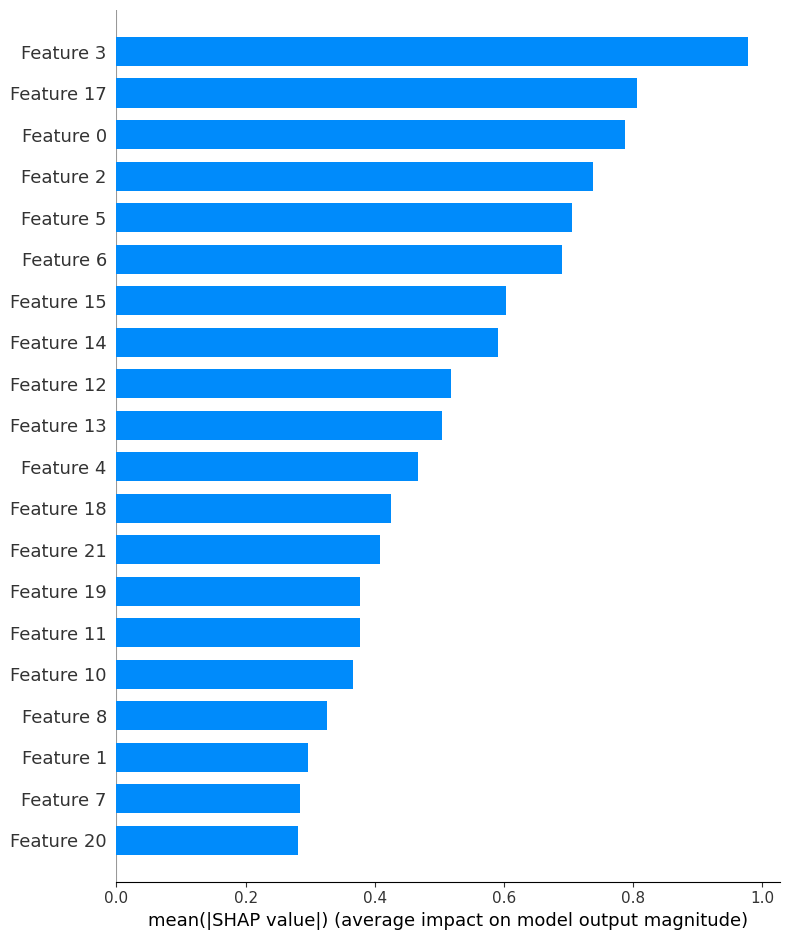

In [ ]:
#SHAP - Feature Importance
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test_final, plot_type="bar", show=True)


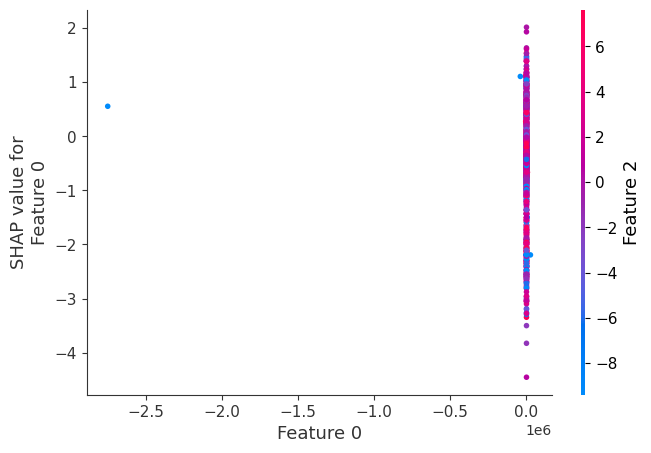

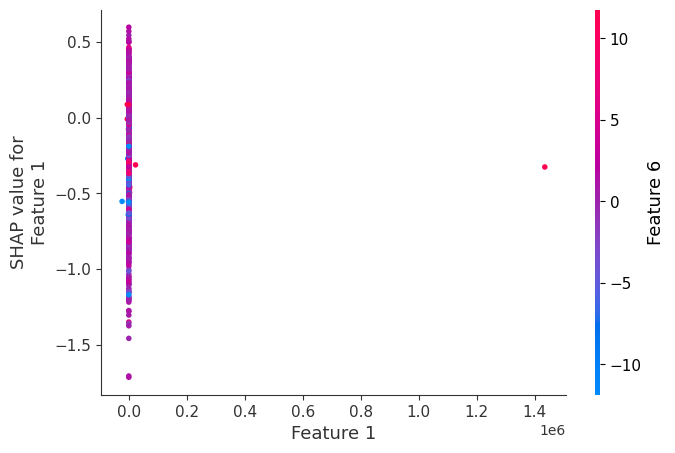

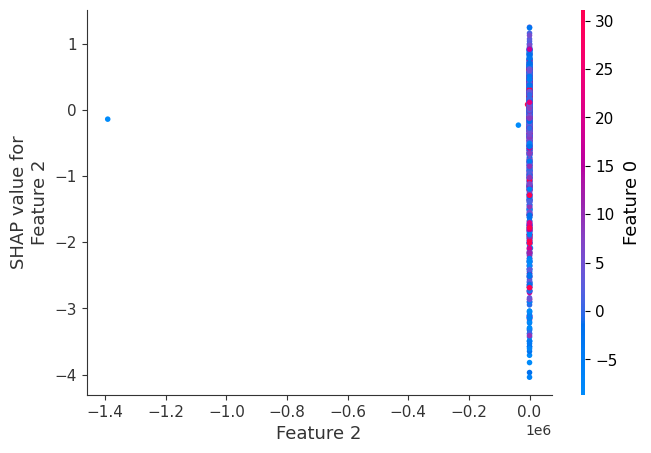

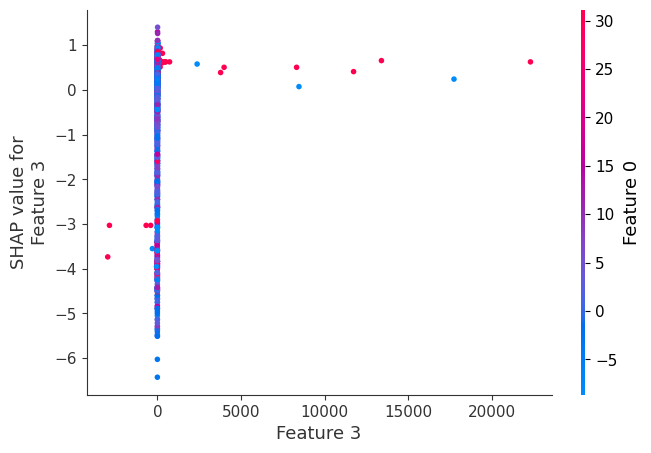

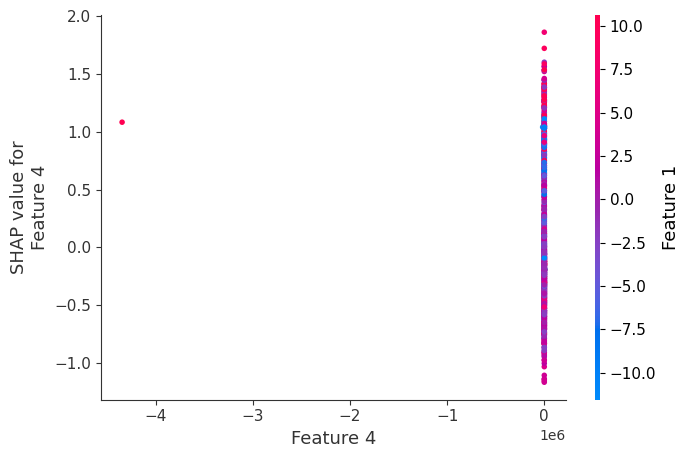

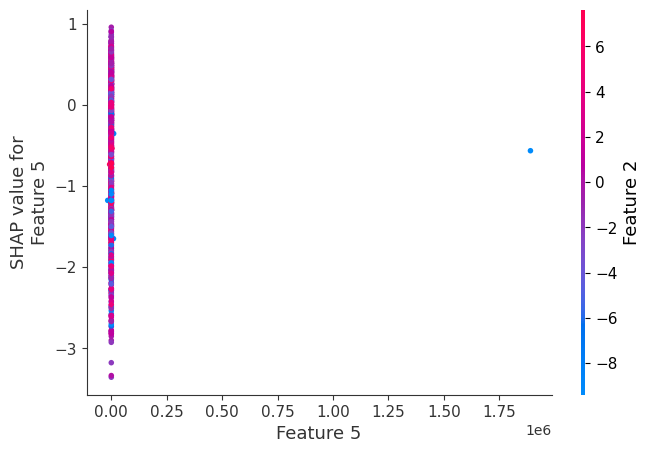

In [ ]:
#SHAP Dependence Plots (Top 6 Features)

for i in range(6):
    shap.dependence_plot(i, shap_values, X_test_final)


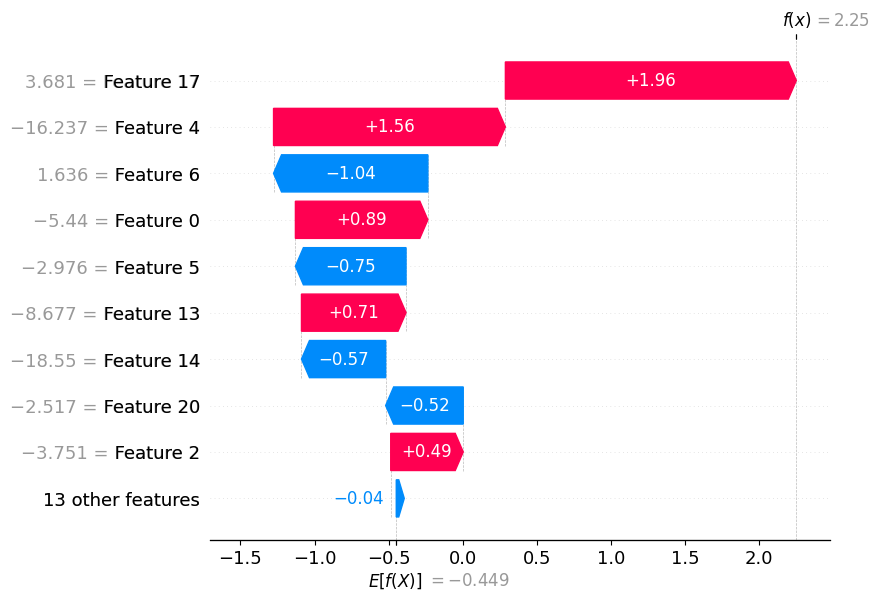

In [ ]:
#SHAP Waterfall Plot (Single Prediction)
# Choosing one sample from the test set
index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[index],
                                     base_values=explainer.expected_value,
                                     data=X_test_final[index]))


# Multi-Year Model Performance Across Forecast Horizons (2-5 Years)


==================== 2year ====================

Missing BEFORE: 12157 | AFTER: 0


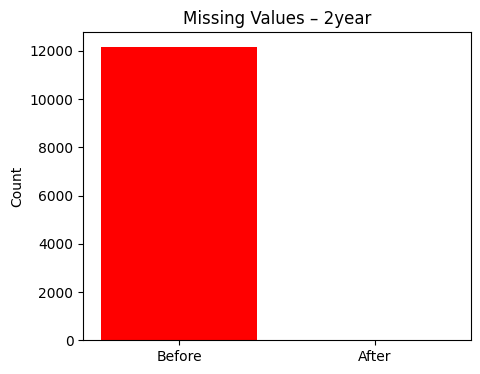

Total Outliers Clipped: 67810


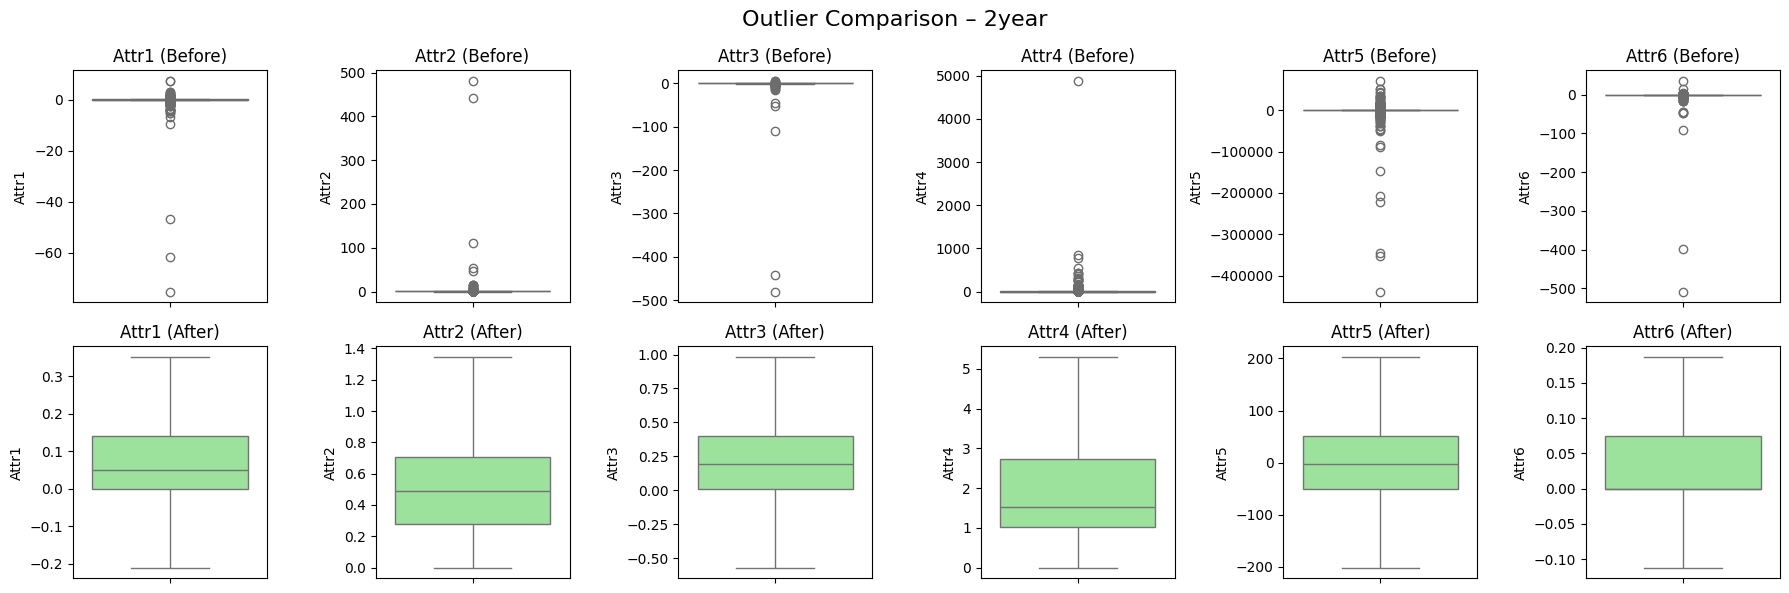

Scaled mean: -0.000, std: 1.000
PCA Components Retained: 24
Variance Explained: 95.10%


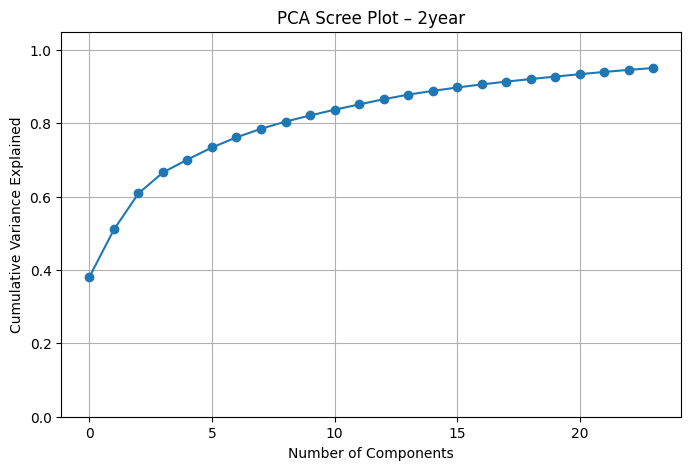

SMOTE BEFORE: Counter({0.0: 7818, 1.0: 320})
SMOTE AFTER:  Counter({0.0: 7818, 1.0: 7818})


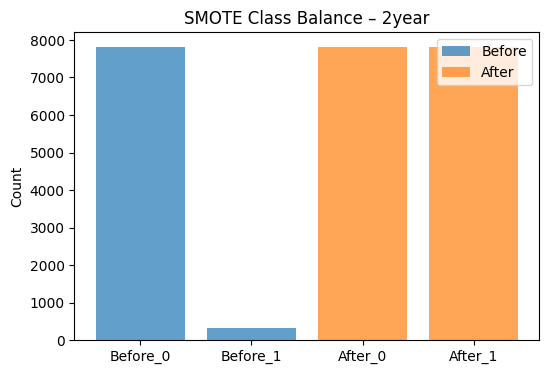




==================== 3year ====================

Missing BEFORE: 9888 | AFTER: 0


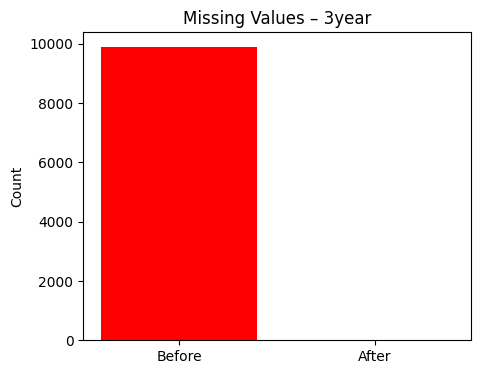

Total Outliers Clipped: 74356


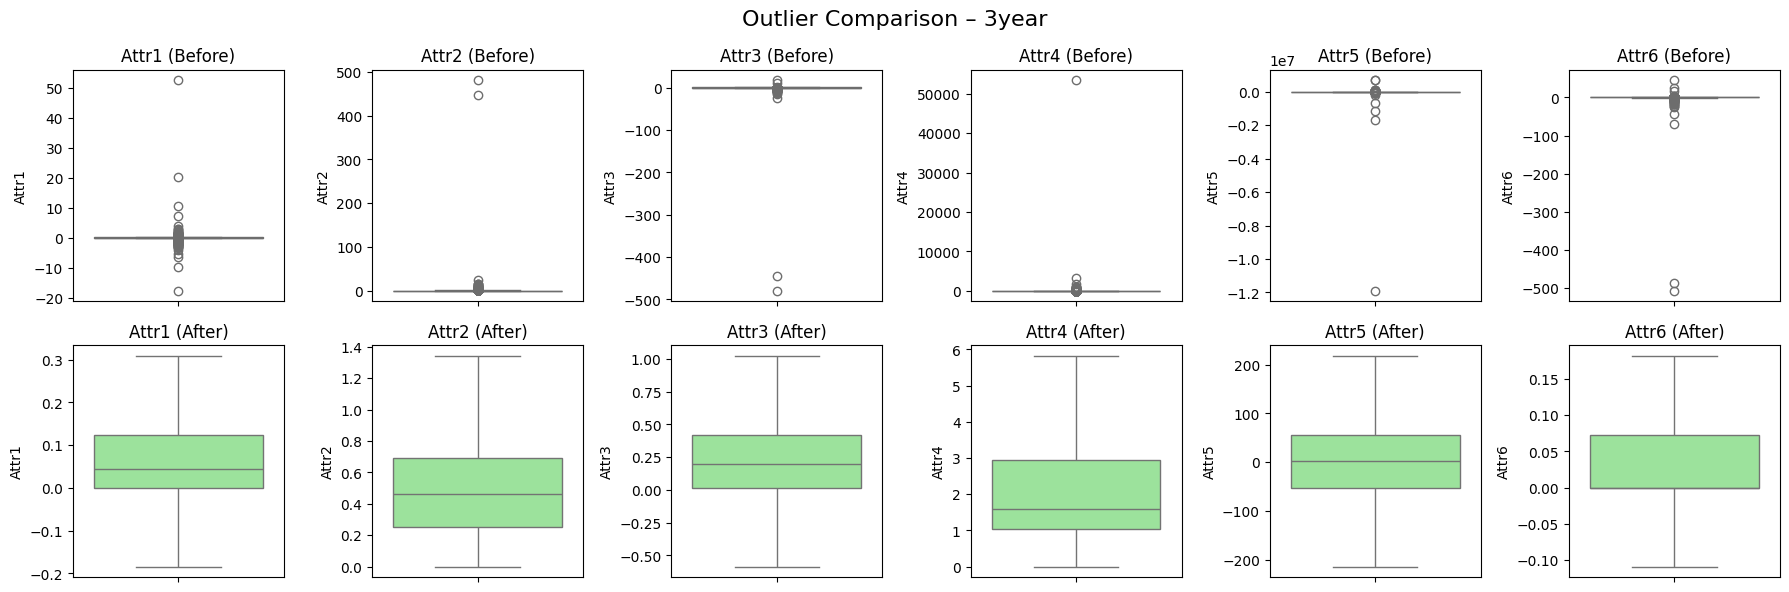

Scaled mean: -0.000, std: 1.000
PCA Components Retained: 25
Variance Explained: 95.44%


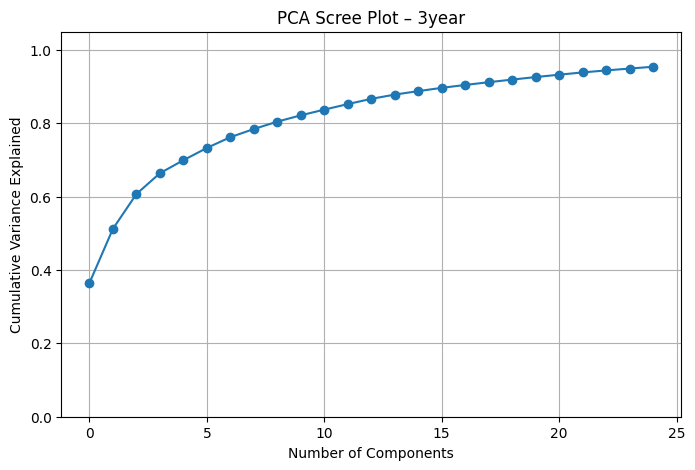

SMOTE BEFORE: Counter({0.0: 8006, 1.0: 396})
SMOTE AFTER:  Counter({0.0: 8006, 1.0: 8006})


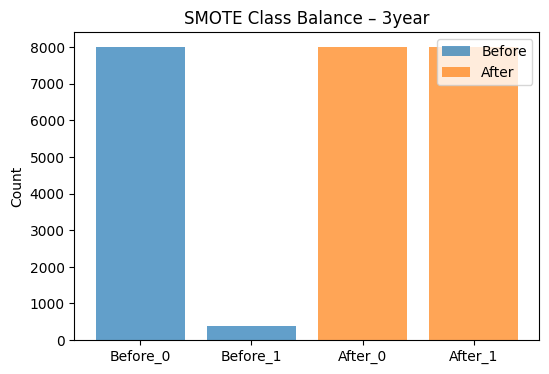




==================== 4year ====================

Missing BEFORE: 8776 | AFTER: 0


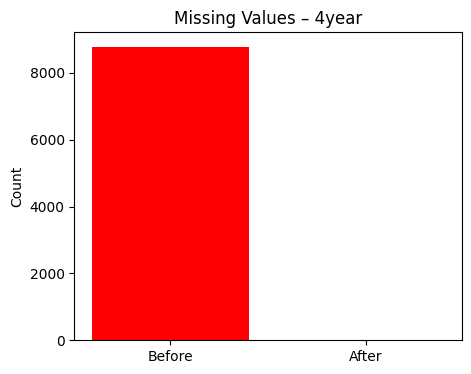

Total Outliers Clipped: 71275


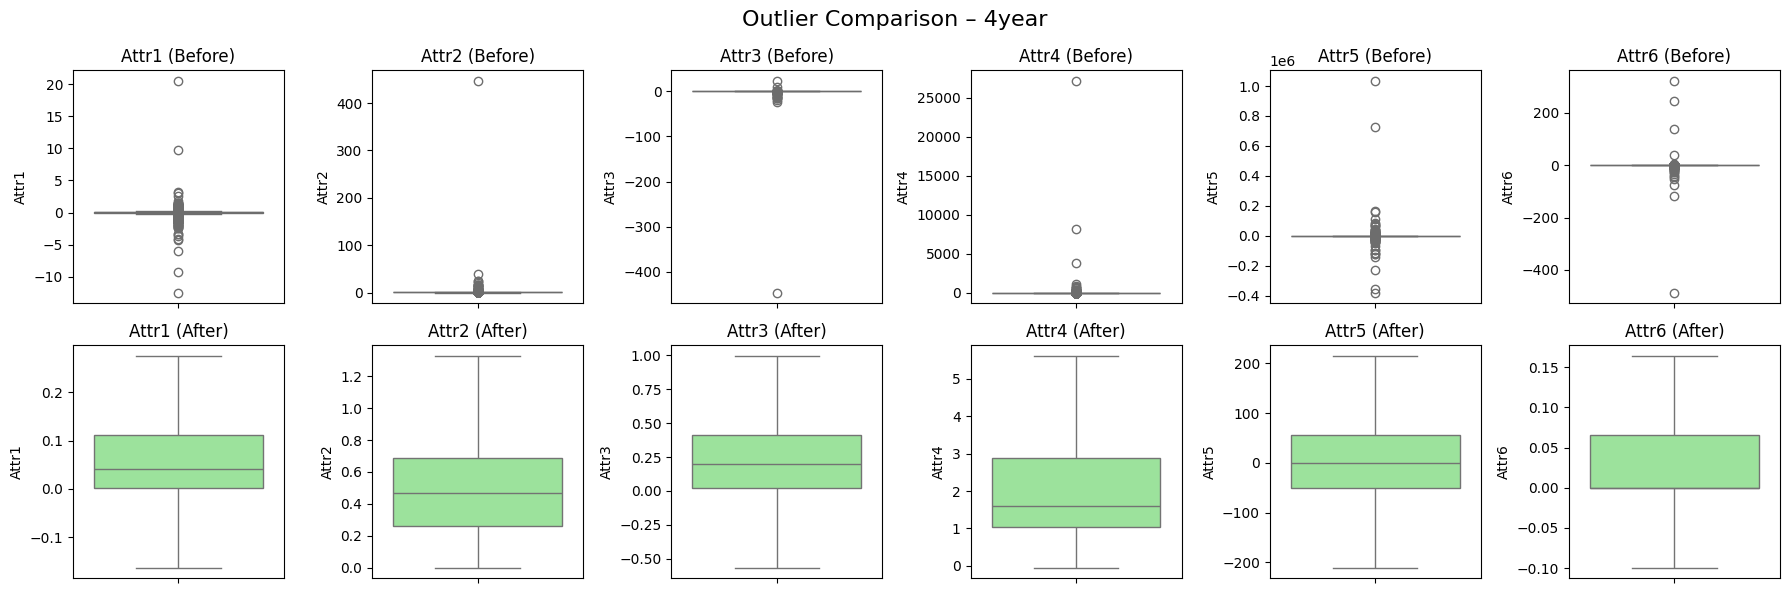

Scaled mean: -0.000, std: 1.000
PCA Components Retained: 25
Variance Explained: 95.38%


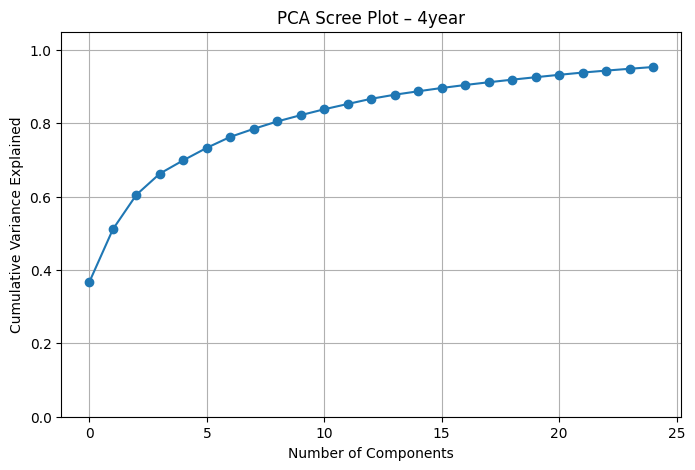

SMOTE BEFORE: Counter({0.0: 7421, 1.0: 412})
SMOTE AFTER:  Counter({0.0: 7421, 1.0: 7421})


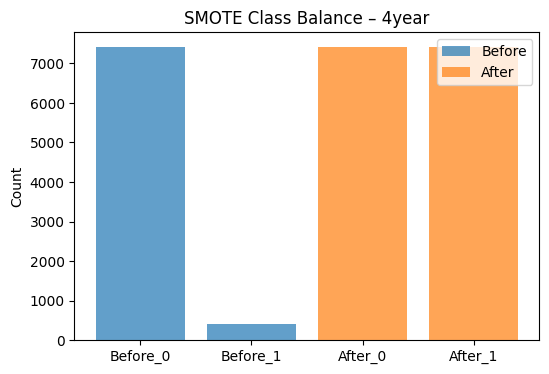




==================== 5year ====================

Missing BEFORE: 4666 | AFTER: 0


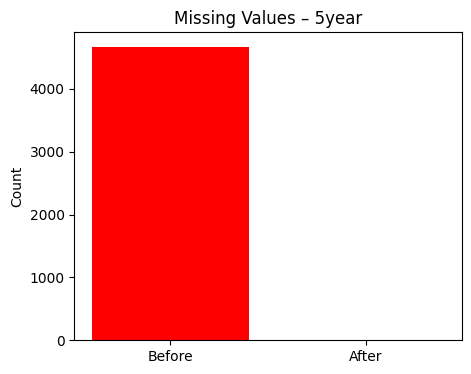

Total Outliers Clipped: 38436


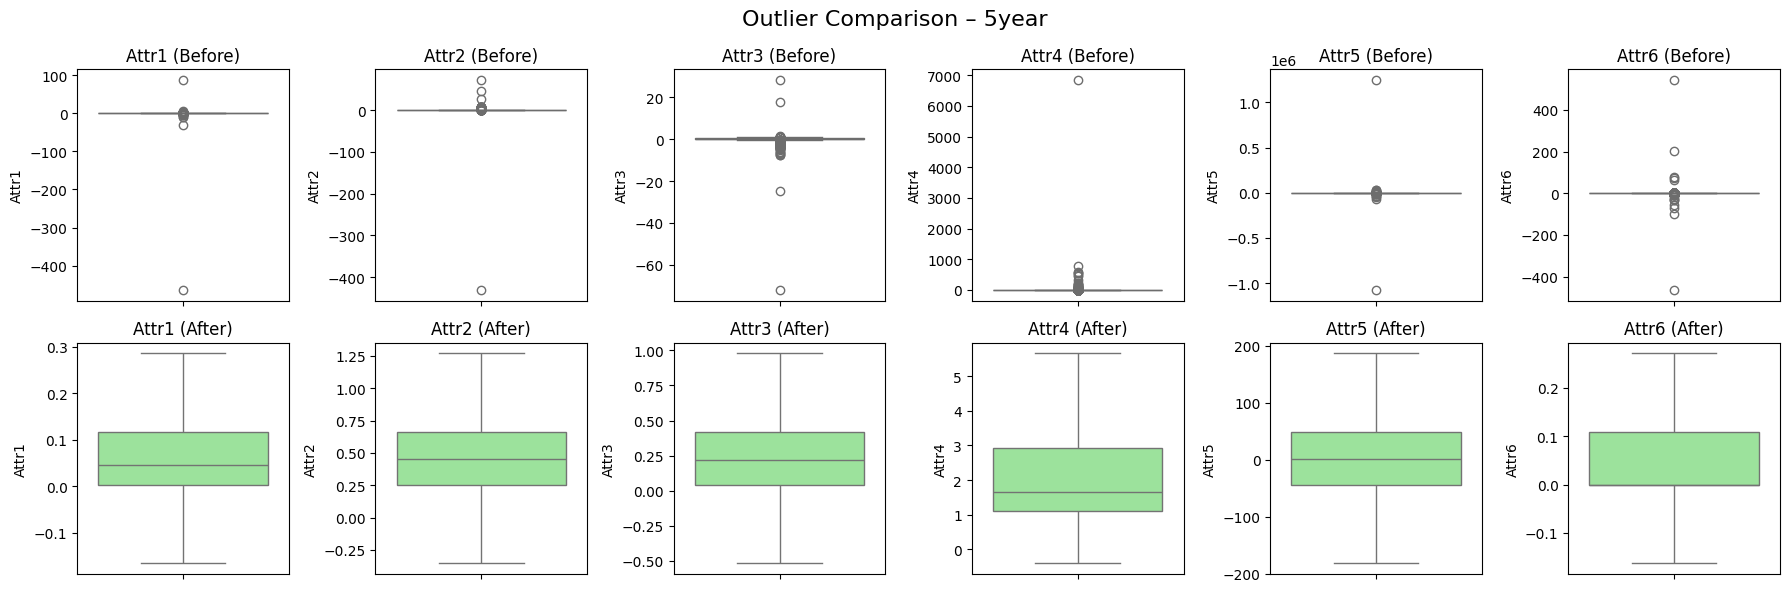

Scaled mean: -0.000, std: 1.000
PCA Components Retained: 24
Variance Explained: 95.36%


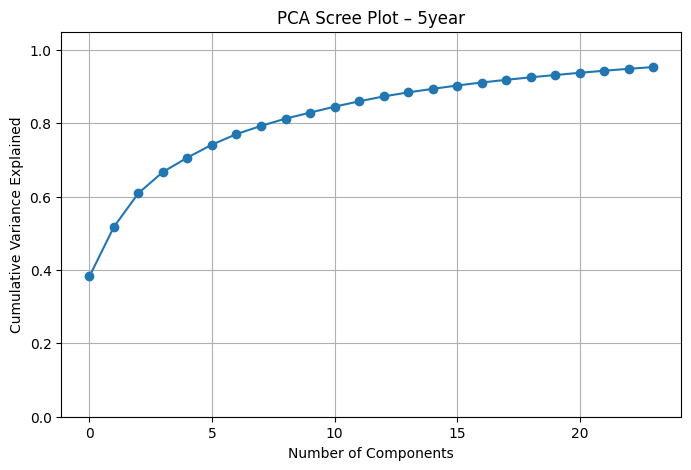

SMOTE BEFORE: Counter({0.0: 4400, 1.0: 328})
SMOTE AFTER:  Counter({0.0: 4400, 1.0: 4400})


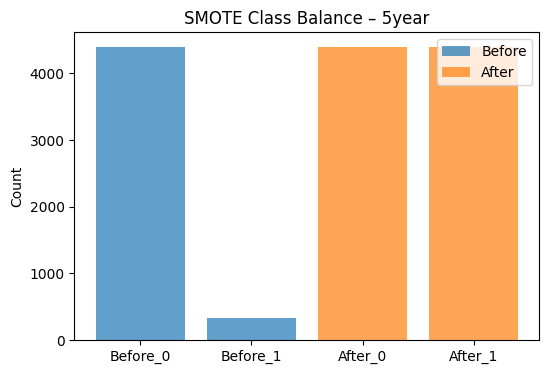

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


#  Raw file paths

file_paths = {
    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}

# Outlier Boxplots (Before vs After)

def plot_outlier_boxplots(df_raw, df_out, year_name):
    numeric_cols = df_raw.drop("class", axis=1).columns[:6]

    fig, axes = plt.subplots(2, len(numeric_cols), figsize=(18, 6))
    fig.suptitle(f"Outlier Comparison – {year_name}", fontsize=16)

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df_raw[col], ax=axes[0, i], color="salmon")
        axes[0, i].set_title(f"{col} (Before)")

        sns.boxplot(y=df_out[col], ax=axes[1, i], color="lightgreen")
        axes[1, i].set_title(f"{col} (After)")

    plt.tight_layout()
    plt.show()


#  PCA Scree Plot

def plot_pca_variance(pca, year_name):
    plt.figure(figsize=(8,5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.title(f"PCA Scree Plot – {year_name}")
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.show()



#  MAIN PREPROCESSING PIPELINE

def preprocess_summary(df, year_name):

    print(f"\n==================== {year_name} ====================\n")

    # Missing Values
    missing_before = df.isna().sum().sum()
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    missing_after = df_imputed.isna().sum().sum()

    print(f"Missing BEFORE: {missing_before} | AFTER: {missing_after}")

    plt.figure(figsize=(5,4))
    plt.bar(["Before", "After"], [missing_before, missing_after], color=["red", "green"])
    plt.title(f"Missing Values – {year_name}")
    plt.ylabel("Count")
    plt.show()

    #  Outlier Clipping
    numeric_cols = df_imputed.drop("class", axis=1).columns
    df_out = df_imputed.copy()
    outlier_count = 0

    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count += ((df_out[col] < lower) | (df_out[col] > upper)).sum()
        df_out[col] = np.clip(df_out[col], lower, upper)

    print(f"Total Outliers Clipped: {outlier_count}")

    # outlier before/after
    plot_outlier_boxplots(df_imputed, df_out, year_name)

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_out.drop("class", axis=1))
    print(f"Scaled mean: {X_scaled.mean():.3f}, std: {X_scaled.std():.3f}")

    # PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA Components Retained: {pca.n_components_}")
    print(f"Variance Explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

    plot_pca_variance(pca, year_name)

    # SMOTE
    X_train, _, y_train, _ = train_test_split(
        df_out.drop("class", axis=1),
        df_out["class"],
        test_size=0.2,
        random_state=42,
        stratify=df_out["class"]
    )

    before = Counter(y_train)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    after = Counter(y_res)

    print(f"SMOTE BEFORE: {before}")
    print(f"SMOTE AFTER:  {after}")

    plt.figure(figsize=(6,4))
    plt.bar(["Before_0", "Before_1"], list(before.values()), alpha=0.7, label="Before")
    plt.bar(["After_0", "After_1"], list(after.values()), alpha=0.7, label="After")
    plt.title(f"SMOTE Class Balance – {year_name}")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    print("\n===========================================\n")



# For all 4 year Datasets

for year_name, path in file_paths.items():
    data, meta = arff.loadarff(path)
    df_raw = pd.DataFrame(data)
    df_raw["class"] = df_raw["class"].astype(int)

    preprocess_summary(df_raw, year_name)


#MODEL TRAINING PIPELINE for 2,3,4,5 years datset

[LightGBM] [Info] Number of positive: 7809, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 15618, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8014, number of negative: 8014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 16028, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7421, number of negative: 7421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 14842, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4408, number of negative: 4408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8816, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================ FINAL MULTI-YEAR RESULTS ================

   Dataset     Model  Accuracy  Precision    Recall  F1-Score       AUC
0    2year   XGBoost  0.957740   0.142857  0.042254  0.065217  0.582072
1    2year  LightGBM  0.946437   0.086957  0.056338  0.068376  0.545746
2    2year  CatBoost  0.956757   0.160000  0.056338  0.083333  0.537825
3    3year   XGBoost  0.933841   0.055556  0.018692  0.027972  0.553975
4    3year  LightGBM  0.926702   0.114754  0.065421  0.083333  0.546703
5    3year  CatBoost  0.933365   0.076923  0.028037  0.041096  0.532460
6    4year   XGBoost  0.938234   0.178571  0.048544  0.076336  0.607882
7    4year  LightGBM  0.934150   0.157895  0.058252  0.085106  0.540360
8    4year  CatBoost  0.939765   0.200000  0.048544  0.078125  0.552629
9    5year   XGBoost  0.923012   0.478261  0.122222  0.194690  0.725697
10   5year  LightGBM  0.917936   0.387097  0.133333  0.198347  0.695884
11   5year  CatBoost  0.921320   0.444444  0.133333  0.205128  0.702091


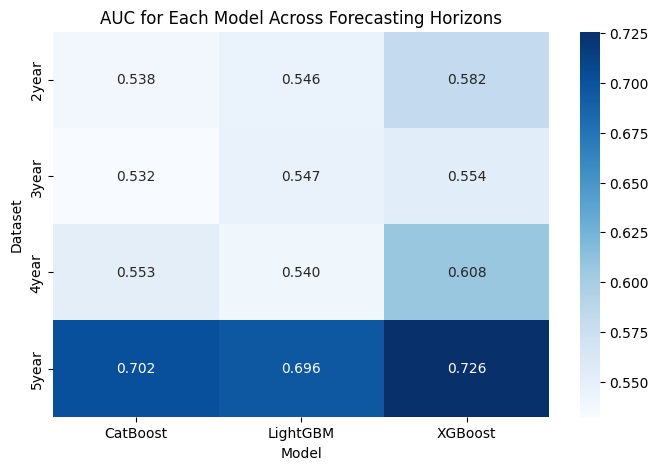

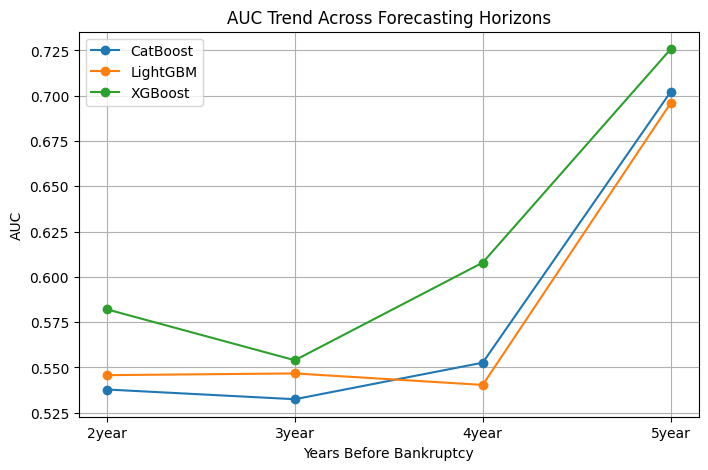

In [ ]:

#MODEL TRAINING PIPELINE


import pandas as pd
import numpy as np
from scipy.io import arff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#  DATASET PATHS
file_paths = {
    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}

#  RESULTS STORAGE
all_results = []

#  PROCESSING
for year, path in file_paths.items():

    # Load dataset
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    df["class"] = df["class"].astype(int)

    X = df.drop("class", axis=1)
    y = df["class"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )

    # Imputation
    imputer = SimpleImputer(strategy="median")
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    # Outlier clipping
    X_train_out = X_train_imp.copy()
    for col in X_train_out.columns:
        Q1 = X_train_out[col].quantile(0.25)
        Q3 = X_train_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        X_train_out[col] = np.clip(X_train_out[col], lower, upper)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_out)
    X_test_scaled = scaler.transform(X_test_imp)

    # PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_pca, y_train)


    #       MODEL TRAINING


    models = {
        "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
        "LightGBM": LGBMClassifier(random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_pca)
        y_prob = model.predict_proba(X_test_pca)[:, 1]

        all_results.append({
            "Dataset": year,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1-Score": f1_score(y_test, y_pred, zero_division=0),
            "AUC": roc_auc_score(y_test, y_prob)
        })

# Final results
final_results_df = pd.DataFrame(all_results)
print("\n================ FINAL MULTI-YEAR RESULTS ================\n")
print(final_results_df)


# Visual plots for better undersatanding


# Pivot table for AUC heatmap
auc_table = final_results_df.pivot(index="Dataset", columns="Model", values="AUC")

plt.figure(figsize=(8,5))
sns.heatmap(auc_table, annot=True, cmap="Blues", fmt=".3f")
plt.title("AUC for Each Model Across Forecasting Horizons")
plt.show()

# Line plot showing AUC trend
plt.figure(figsize=(8,5))
for model in auc_table.columns:
    plt.plot(auc_table.index, auc_table[model], marker="o", label=model)

plt.title("AUC Trend Across Forecasting Horizons")
plt.xlabel("Years Before Bankruptcy")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

# Saving results
final_results_df.to_csv("All_Years_Model_Results.csv", index=False)


In [ ]:
#   IMPORTS
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#  Dataset FOR ALL YEARS
file_paths = {

    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}

#  FINAL RESULTS STORAGE
all_results = []

# PROCESSING LOOP FOR ALL YEARS
for year, path in file_paths.items():
    print(f"\n================= PROCESSING {year} =================\n")

    #  Load dataset
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    df['class'] = df['class'].astype(int)

    X = df.drop("class", axis=1)
    y = df["class"]

    #  Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )

    # Missing Value Imputation
    imputer = SimpleImputer(strategy="median")
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    #  Outlier Treatment
    X_train_out = X_train_imp.copy()
    for col in X_train_out.columns:
        Q1 = X_train_out[col].quantile(0.25)
        Q3 = X_train_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        X_train_out[col] = np.clip(X_train_out[col], lower, upper)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_out)
    X_test_scaled = scaler.transform(X_test_imp)

    # PCA (95% variance)
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_pca, y_train)


    #  MODEL TRAINING (3 MODELS)


    models = {
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
    }

    for model_name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_pca)
        y_prob = model.predict_proba(X_test_pca)[:, 1]

        # collect results
        all_results.append({
            "Dataset": year,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_prob)
        })

# FINAL RESULTS TABLE
final_results_df = pd.DataFrame(all_results)
print("\n================= FINAL MULTI-YEAR MODEL RESULTS =================\n")
print(final_results_df)

#  Saving results
final_results_df.to_csv("All_Years_Model_Results.csv", index=False)



================= PROCESSING 2year =================

[LightGBM] [Info] Number of positive: 7809, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 15618, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================= PROCESSING 3year =================

[LightGBM] [Info] Number of positive: 8014, number of negative: 8014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 16028, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================= PROCESSING 4year =================

[LightGBM] [Info] Number of positive: 7421, number of negative: 7421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 14842, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================= PROCESSING 5year =================

[LightGBM] [Info] Number of positive: 4408, number of negative: 4408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8816, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



================= FINAL MULTI-YEAR MODEL RESULTS =================

   Dataset     Model  Accuracy  Precision    Recall  F1-Score       AUC
0    2year   XGBoost  0.957740   0.142857  0.042254  0.065217  0.582072
1    2year  LightGBM  0.946437   0.086957  0.056338  0.068376  0.545746
2    2year  CatBoost  0.956757   0.160000  0.056338  0.083333  0.537825
3    3year   XGBoost  0.933841   0.055556  0.018692  0.027972  0.553975
4    3year  LightGBM  0.926702   0.114754  0.065421  0.083333  0.546703
5    3year  CatBoost  0.933365   0.076923  0.028037  0.041096  0.532460
6    4year   XGBoost  0.938234   0.178571  0.048544  0.076336  0.607882
7    4year  LightGBM  0.934150   0.157895  0.058252  0.085106  0.540360
8    4year  CatBoost  0.939765   0.200000  0.048544  0.078125  0.552629
9    5year   XGBoost  0.923012   0.478261  0.122222  0.194690  0.725697
10   5year  LightGBM  0.917936   0.387097  0.133333  0.198347  0.695884
11   5year  CatBoost  0.921320   0.444444  0.133333  0.205128  0.70

Across all forecasting horizons, the 5-year dataset produced the best discrimination between bankrupt and non-bankrupt firms (AUC up to 0.73 with XGBoost), while shorter horizons (2-4 years) remained harder, with AUC around 0.55-0.60.

The 5-Year dataset gives the strongest signal for predicting bankruptcy risk, and XGBoost performs best on that horizon in terms of AUC

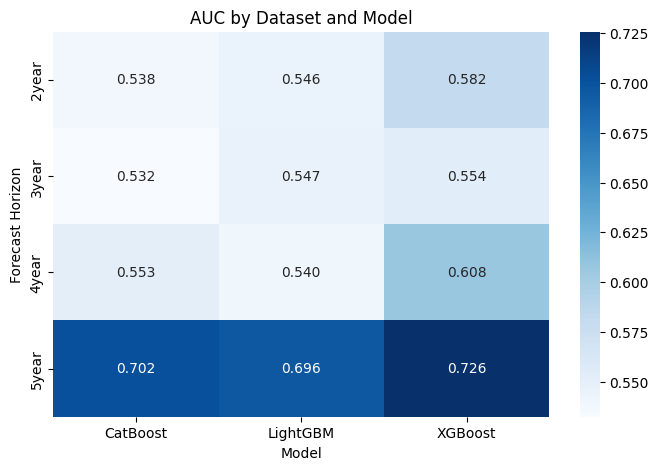

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the final_results_df you already created
auc_pivot = final_results_df.pivot(index="Dataset", columns="Model", values="AUC")

plt.figure(figsize=(8, 5))
sns.heatmap(auc_pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("AUC by Dataset and Model")
plt.ylabel("Forecast Horizon")
plt.xlabel("Model")
plt.show()


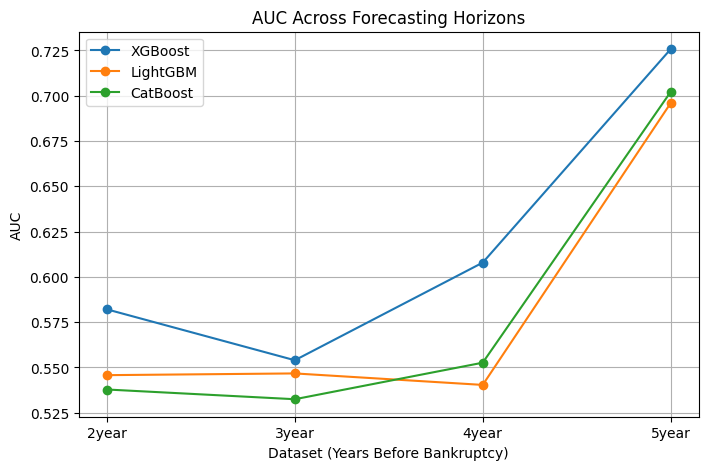

In [ ]:
plt.figure(figsize=(8,5))
for model in final_results_df["Model"].unique():
    subset = final_results_df[final_results_df["Model"] == model]
    plt.plot(subset["Dataset"], subset["AUC"], marker="o", label=model)

plt.title("AUC Across Forecasting Horizons")
plt.xlabel("Dataset (Years Before Bankruptcy)")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()


I repeated the full preprocessing and modeling pipeline on all 2-5 year datasets.

Accuracy stays high for all years, but recall remains low, confirming the difficulty of detecting bankrupt firms.

The 5-year dataset gives the best AUC (up to ~0.73 with XGBoost), suggesting that early financial patterns five years before failure carry stronger predictive signals than intermediate horizons (2-4 years).

 # MULTI-YEAR MODEL TUNING PIPELINE

In [ ]:

# MULTI-YEAR MODEL TUNING PIPELINE


import pandas as pd
import numpy as np
from scipy.io import arff

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")


#Dataset Paths

file_paths = {
    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}


#   Hyperparameter Grids


xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

lgbm_param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 5, 7],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10]
}

cat_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}


# function for tuning


def tune_model(model, param_grid, X, y):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=5,
        scoring="roc_auc",
        cv=2,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X, y)
    return search.best_estimator_, search.best_params_, search.best_score_

# Storing final results

final_results = []


#MAIN LOOP

for year, path in file_paths.items():

    print(f"\n================== TUNING {year} ==================\n")

    # Load data
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    df["class"] = df["class"].astype(int)

    X = df.drop("class", axis=1)
    y = df["class"]

    # Preprocessing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )

    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(imputer.fit_transform(X_train))
    X_test = pd.DataFrame(imputer.transform(X_test))

    # Outlier Clipping
    for col in X_train.columns:
        Q1, Q3 = X_train[col].quantile(0.25), X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        X_train[col] = np.clip(X_train[col], lower, upper)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_pca, y_train)


    # TUNE XGBoost, LightGBM, CatBoost


    #  XGBoost
    best_xgb, xgb_params, xgb_auc = tune_model(
        XGBClassifier(random_state=42, eval_metric="logloss"),
        xgb_param_grid,
        X_res, y_res
    )

    #  LightGBM
    best_lgbm, lgbm_params, lgbm_auc = tune_model(
        LGBMClassifier(random_state=42),
        lgbm_param_grid,
        X_res, y_res
    )

    #  CatBoost
    best_cat, cat_params, cat_auc = tune_model(
        CatBoostClassifier(verbose=0, random_state=42),
        cat_param_grid,
        X_res, y_res
    )


    #      Evaluating each tuned model


    tuned_models = {
        "XGBoost_Tuned": best_xgb,
        "LightGBM_Tuned": best_lgbm,
        "CatBoost_Tuned": best_cat
    }

    for name, model in tuned_models.items():
        y_pred = model.predict(X_test_pca)
        y_prob = model.predict_proba(X_test_pca)[:, 1]

        final_results.append({
            "Dataset": year,
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_prob)
        })


#   Final Summary Table

tuned_results_df = pd.DataFrame(final_results)
print("\n================== FINAL TUNED MODEL RESULTS ==================\n")
print(tuned_results_df)

tuned_results_df.to_csv("All_Years_Tuned_Results.csv", index=False)



================== TUNING 2year ==================

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 7809, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 15618, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting 2 folds for each of 5 candidates, totalling 10 fits

================== TUNING 3year ==================

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 8014, number of negative: 8014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

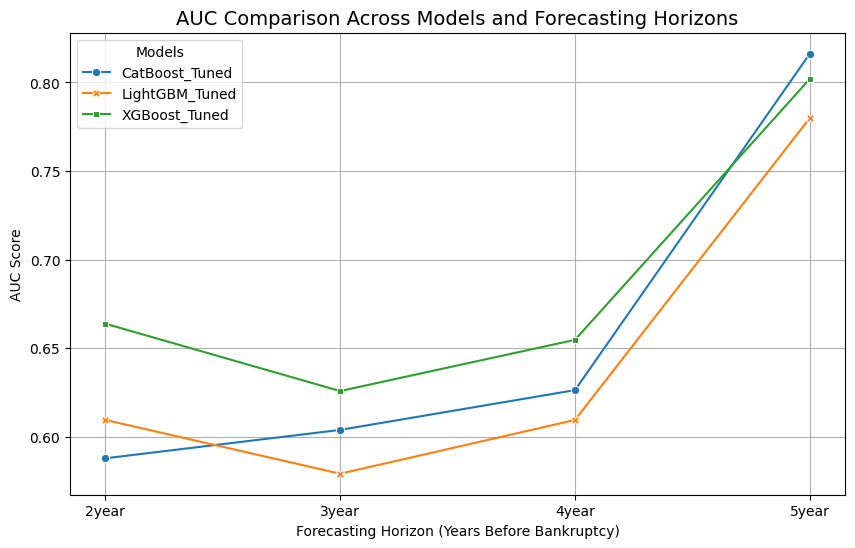

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# tuned results dataframe
tuned_results = pd.DataFrame({
    "Dataset": ["2year","2year","2year","3year","3year","3year","4year","4year","4year","5year","5year","5year"],
    "Model": [
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned"
    ],
    "AUC": [
        0.663912, 0.609614, 0.587942,
        0.625899, 0.579252, 0.603968,
        0.654780, 0.609576, 0.626405,
        0.801989, 0.779940, 0.816204
    ]
})

# Pivot for plotting
auc_pivot = tuned_results.pivot(index="Dataset", columns="Model", values="AUC")

plt.figure(figsize=(10,6))
sns.lineplot(data=auc_pivot, markers=True, dashes=False)

plt.title("AUC Comparison Across Models and Forecasting Horizons", fontsize=14)
plt.xlabel("Forecasting Horizon (Years Before Bankruptcy)")
plt.ylabel("AUC Score")
plt.grid(True)
plt.legend(title="Models")
plt.show()


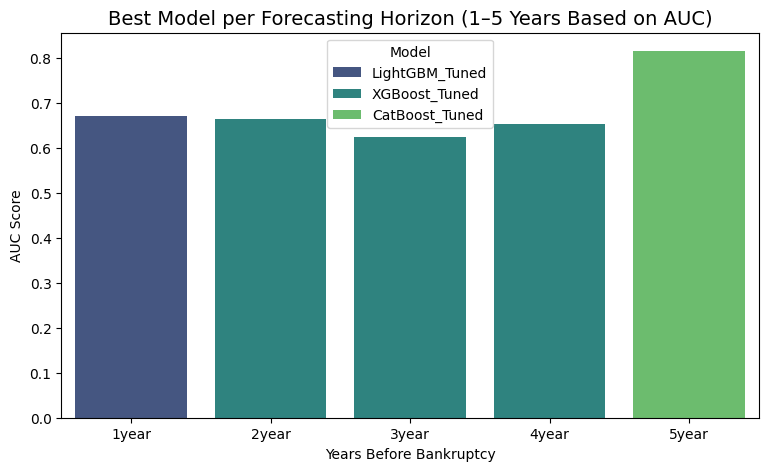

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1-year tuned results (from your notebook)
one_year_results = pd.DataFrame({
    "Dataset": ["1year", "1year", "1year"],
    "Model": ["XGBoost_Tuned", "LightGBM_Tuned", "CatBoost_Tuned"],
    "AUC": [0.652648, 0.671878, 0.660934]
})

# 2–5 year tuned results
tuned_results = pd.DataFrame({
    "Dataset": ["2year","2year","2year","3year","3year","3year","4year","4year","4year","5year","5year","5year"],
    "Model": [
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned",
        "XGBoost_Tuned","LightGBM_Tuned","CatBoost_Tuned"
    ],
    "AUC": [
        0.663912, 0.609614, 0.587942,
        0.625899, 0.579252, 0.603968,
        0.654780, 0.609576, 0.626405,
        0.801989, 0.779940, 0.816204
    ]
})

# Combine 1-year + 2-5 years
all_years_results = pd.concat([one_year_results, tuned_results], ignore_index=True)

# Best model per year
best_models = all_years_results.loc[all_years_results.groupby("Dataset")["AUC"].idxmax()]

plt.figure(figsize=(9,5))
sns.barplot(data=best_models, x="Dataset", y="AUC", hue="Model", palette="viridis")

plt.title("Best Model per Forecasting Horizon (1–5 Years Based on AUC)", fontsize=14)
plt.ylabel("AUC Score")
plt.xlabel("Years Before Bankruptcy")
plt.show()


In [ ]:
#original feature importance


==================== 1year — LightGBM ====================

[LightGBM] [Info] Number of positive: 5404, number of negative: 5404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 10808, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


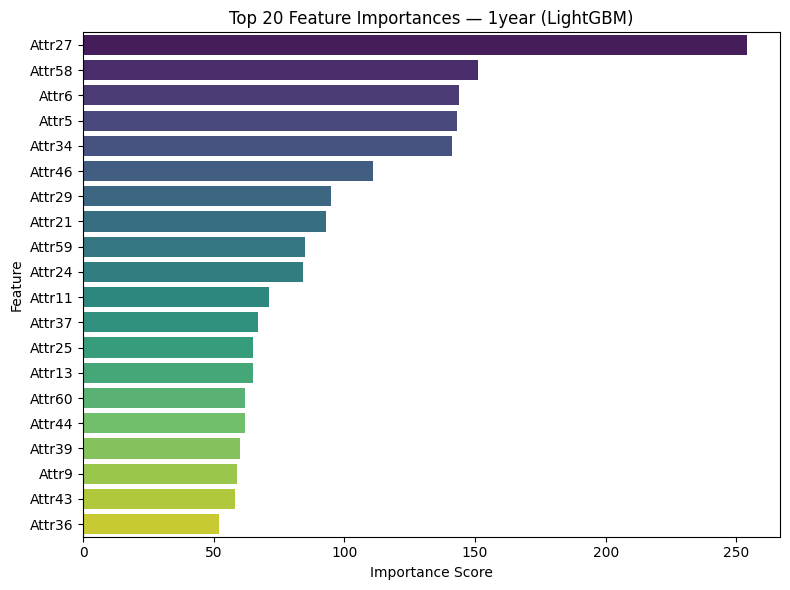


==================== 2year — XGBoost ====================



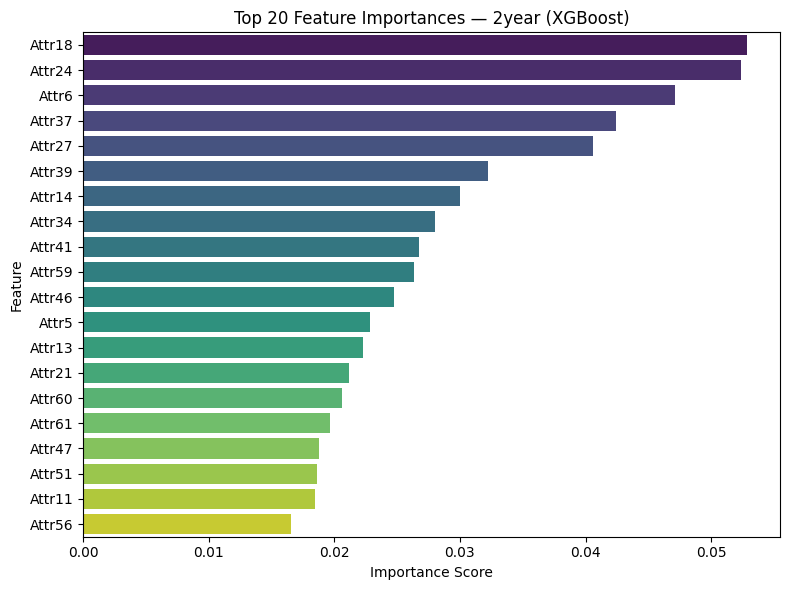


==================== 3year — XGBoost ====================



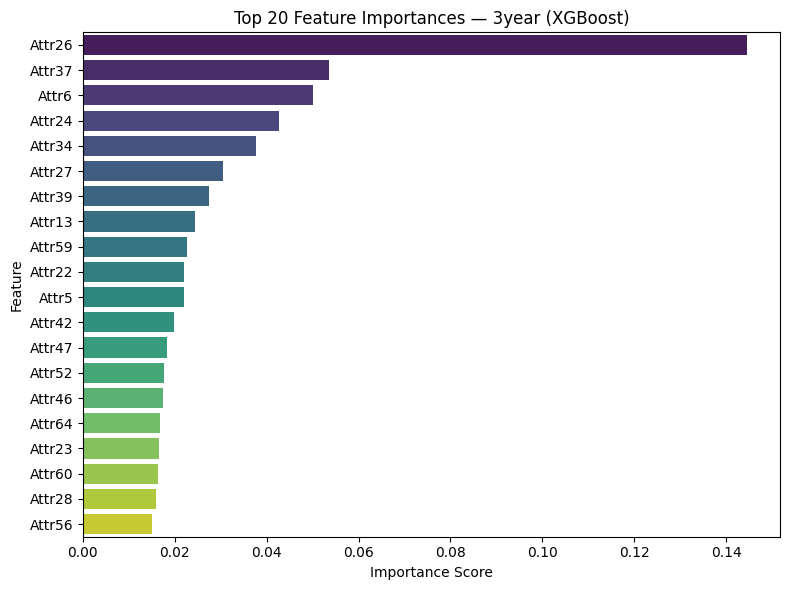


==================== 4year — XGBoost ====================



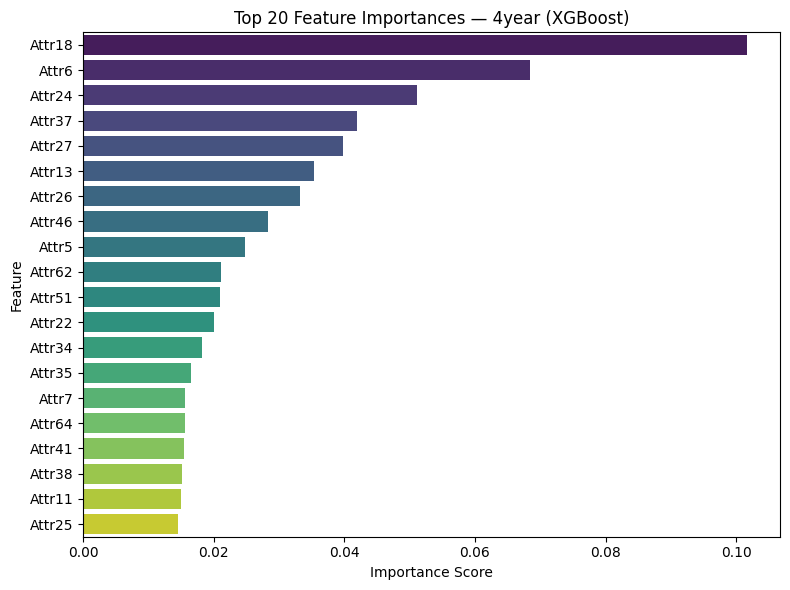


==================== 5year — CatBoost ====================



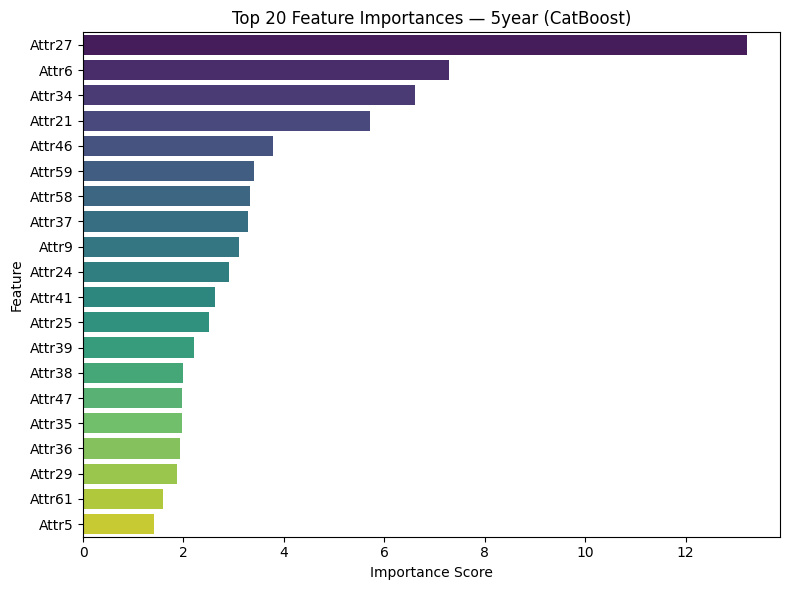

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



#  BEST MODEL

best_models = {
    "1year": ("LightGBM", LGBMClassifier(random_state=42)),
    "2year": ("XGBoost", XGBClassifier(random_state=42, eval_metric="logloss")),
    "3year": ("XGBoost", XGBClassifier(random_state=42, eval_metric="logloss")),
    "4year": ("XGBoost", XGBClassifier(random_state=42, eval_metric="logloss")),
    "5year": ("CatBoost", CatBoostClassifier(verbose=0, random_state=42))
}


#  DATASET LOCATIONS

file_paths = {
    "1year": "/content/1year.arff",
    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}


#   FUNCTION FOR ORIGINAL FEATURE IMPORTANCE

def original_feature_importance(year_name, model_name, model, file_path):

    print(f"\n==================== {year_name} — {model_name} ====================\n")

    # Load dataset
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    df["class"] = df["class"].astype(int)

    X = df.drop("class", axis=1)
    y = df["class"]
    feature_names = X.columns

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    # Imputation
    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_names)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=feature_names)

    # Outlier Clipping
    X_train_out = X_train.copy()
    for col in feature_names:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        X_train_out[col] = np.clip(X_train[col], lower, upper)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_out)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

    # Train best model
    model.fit(X_res, y_res)


    #  GET ORIGINAL FEATURE IMPORTANCE

    if model_name == "CatBoost":
        importances = model.get_feature_importance()
    else:
        importances = model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Top 20 features
    top20 = importance_df.head(20)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=top20, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top 20 Feature Importances — {year_name} ({model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return importance_df



#  FOR ALL 5 YEARS

all_year_feature_importances = {}

for year_name, (model_label, model_obj) in best_models.items():
    imp_df = original_feature_importance(
        year_name,
        model_label,
        model_obj,
        file_paths[year_name]
    )
    all_year_feature_importances[year_name] = imp_df



=========== Processing 1year Dataset ===========
[LightGBM] [Info] Number of positive: 220, number of negative: 5401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5621, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039139 -> initscore=-3.200712
[LightGBM] [Info] Start training from score -3.200712

=========== Processing 2year Dataset ===========

=========== Processing 3year Dataset ===========

=========== Processing 4year Dataset ===========

=========== Processing 5year Dataset ===========

=========== RAW FEATURE IMPORTANCE DICTIONARIES ===========

1year = {'Attr15': np.float64(253.35287843211617), 'Attr5': np.float64(201.3474253601354), 'Attr59': np.float64(189.5312600189497), 'A

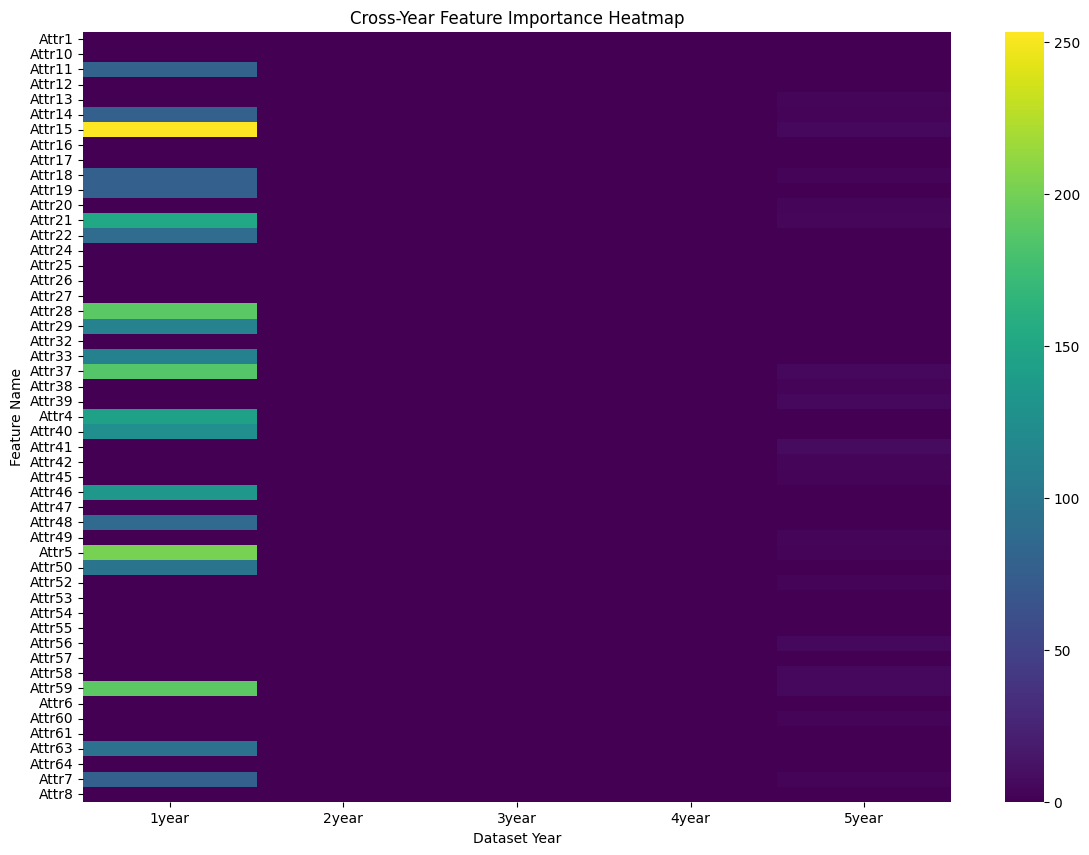

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns


#  FILE PATHS
file_paths = {
    "1year": "/content/1year.arff",
    "2year": "/content/2year.arff",
    "3year": "/content/3year.arff",
    "4year": "/content/4year.arff",
    "5year": "/content/5year.arff"
}

# Best model per year
best_models = {
    "1year": LGBMClassifier(random_state=42),
    "2year": XGBClassifier(random_state=42),
    "3year": XGBClassifier(random_state=42),
    "4year": XGBClassifier(random_state=42),
    "5year": CatBoostClassifier(verbose=0, random_state=42)
}

feature_importance_dict = {}


#  LOOP THROUGH ALL YEARS
for year, path in file_paths.items():

    print(f"\n=========== Processing {year} Dataset ===========")

    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    df["class"] = df["class"].astype(int)

    X = df.drop("class", axis=1)
    y = df["class"]

    # Preprocessing
    X_imp = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X), columns=X.columns)
    X_scaled = StandardScaler().fit_transform(X_imp)

    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    model = best_models[year]
    model.fit(X_train, y_train)

    # Extract raw feature importance from model
    if hasattr(model, "feature_importances_"):
        raw_importances = model.feature_importances_
    else:
        raw_importances = model.get_feature_importance()

    # Convert PCA importances back to original feature space
    pca_back_projected = np.abs(np.dot(raw_importances, pca.components_))
    pca_back_projected = pca_back_projected[:len(X.columns)]

    # Top 20 features
    importance_dict = {X.columns[i]: pca_back_projected[i] for i in range(len(X.columns))}
    importance_dict = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20])

    feature_importance_dict[year] = importance_dict


# Print Raw Dictionaries
print("\n=========== RAW FEATURE IMPORTANCE DICTIONARIES ===========\n")
for year in feature_importance_dict:
    print(f"{year} = {feature_importance_dict[year]}\n")


#  BUILD CROSS-YEAR MATRIX
print("\n=========== Building Cross-Year Matrix ===========\n")

#  Convert feature set , sorted list
all_features = sorted(set().union(*[fi.keys() for fi in feature_importance_dict.values()]))

# Empty dataframe with sorted features
cross_year_df = pd.DataFrame(index=all_features)

# Fill matrix
for year in feature_importance_dict:
    cross_year_df[year] = cross_year_df.index.map(
        lambda f: feature_importance_dict[year].get(f, 0)
    )


#  HEATMAP
plt.figure(figsize=(14, 10))
sns.heatmap(cross_year_df, annot=False, cmap="viridis")
plt.title("Cross-Year Feature Importance Heatmap")
plt.xlabel("Dataset Year")
plt.ylabel("Feature Name")
plt.show()
